# **Bibliotecas e Instalações**

In [1]:
%%capture

!pip install shap
!pip install optuna
!pip install cmaes

In [2]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

In [3]:
# !pip install --upgrade --no-cache-dir gdown --quiet
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

In [4]:
figures_path = '/content/drive/MyDrive/Trabalho/Cancer/Predição cruzada/Sobrevida 3 anos/Figuras'

In [5]:
def plot_confusion_matrix_v2(model, x, y, format='.5f', ax=None):
    """
    Plota uma matriz de confusão normalizada e um relatório de classificação.

    Parâmetros:
    -----------
    model : estimador
        Um modelo de classificação já treinado.
    x : array-like, shape (n_samples, n_features)
        Conjunto de teste com as features.
    y : array-like, shape (n_samples,)
        Conjunto de teste com o label.
    format : str, opcional (padrão='.3f')
        O formato a ser usado para os valores na matriz de confusão.

    Retorno:
    --------
    None

    """
    with plt.rc_context({'font.size': 10, 'font.weight': 'bold'}):
        ConfusionMatrixDisplay.from_estimator(model, x, y, values_format=format,
                                              cmap='binary', normalize='true',
                                              ax=ax, colorbar=False)

# **Individuais**

In [6]:
# Baixando todos os arquivos dos tipos de câncer
!gdown 1-5P81yj29-MTfd3qBpCPG3xcYjVdsRU1 --quiet # Sistema Digestório

# Leitura dos dados
df = pd.read_csv('sist_dig.csv')
print(df.shape)
df.head(3)

(140312, 32)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,EC,TRATHOSP,NENHUM,...,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,obito_geral,sobrevida_ano1,sobrevida_ano3,sobrevida_ano5
0,55,1,3518701,9,2,C049,C04,IVA,C,0,...,7,3518701,1,3.0,1,0,1,0,0,0
1,62,1,3518701,9,1,C060,C06,IVB,C,0,...,7,3518701,1,2.0,1,0,1,0,0,0
2,54,1,3518701,2,1,C019,C01,IVC,E,0,...,7,3518701,1,2.0,1,0,1,0,0,0


In [7]:
# Dados
df_boca = df[df.TOPOGRUP.isin(['C00', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06'])]
df_boca = df_boca[~((df_boca.obito_geral == 0) & (df_boca.sobrevida_ano3 == 0))].reset_index(drop=True)

df_oro = df[df.TOPOGRUP.isin(['C10'])]
df_oro = df_oro[~((df_oro.obito_geral == 0) & (df_oro.sobrevida_ano3 == 0))].reset_index(drop=True)

df_eso = df[df.TOPOGRUP.isin(['C15'])]
df_eso = df_eso[~((df_eso.obito_geral == 0) & (df_eso.sobrevida_ano3 == 0))].reset_index(drop=True)

df_esto = df[df.TOPOGRUP.isin(['C16'])]
df_esto = df_esto[~((df_esto.obito_geral == 0) & (df_esto.sobrevida_ano3 == 0))].reset_index(drop=True)

df_delg = df[df.TOPOGRUP.isin(['C17'])]
df_delg = df_delg[~((df_delg.obito_geral == 0) & (df_delg.sobrevida_ano3 == 0))].reset_index(drop=True)

df_colo = df[df.TOPOGRUP.isin(['C18', 'C19', 'C20'])]
df_colo = df_colo[~((df_colo.obito_geral == 0) & (df_colo.sobrevida_ano3 == 0))].reset_index(drop=True)

df_anus = df[df.TOPOGRUP.isin(['C21'])]
df_anus = df_anus[~((df_anus.obito_geral == 0) & (df_anus.sobrevida_ano3 == 0))].reset_index(drop=True)

df_boca.shape, df_oro.shape, df_eso.shape, df_esto.shape, df_delg.shape, df_colo.shape, df_anus.shape

((23935, 32),
 (4922, 32),
 (13961, 32),
 (27770, 32),
 (1594, 32),
 (56111, 32),
 (2276, 32))

## **Cavidade Oral**

In [8]:
# Valores faltantes
df_boca.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [9]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_boca, X_test_boca, y_train_boca, y_test_boca, feat_cols, enc, norm = preprocessing(df_boca,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (17951, 23), X_test = (5984, 23)
y_train = (17951,), y_test = (5984,)


### **XGBoost**


#### **Modelo base**

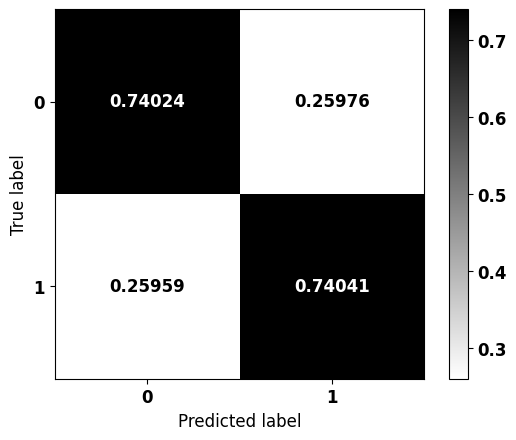


              precision    recall  f1-score   support

           0    0.80443   0.74024   0.77100      3534
           1    0.66398   0.74041   0.70012      2450

    accuracy                        0.74031      5984
   macro avg    0.73421   0.74032   0.73556      5984
weighted avg    0.74693   0.74031   0.74198      5984



In [10]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=1.403,
                    random_state=seed)

xgb.fit(X_train_boca, y_train_boca)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test_boca, y_test_boca)

#### **Optuna**

In [11]:
params = {'n_estimators': 115,
 'max_depth': 4,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 3,
 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 1.4307

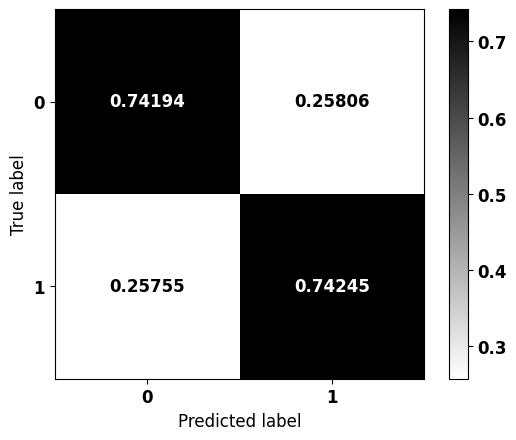


              precision    recall  f1-score   support

           0    0.80603   0.74194   0.77265      3534
           1    0.66606   0.74245   0.70218      2450

    accuracy                        0.74215      5984
   macro avg    0.73604   0.74219   0.73742      5984
weighted avg    0.74872   0.74215   0.74380      5984



In [12]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train_boca, y_train_boca)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test_boca, y_test_boca)

### **LightGBM**


#### **Modelo base**

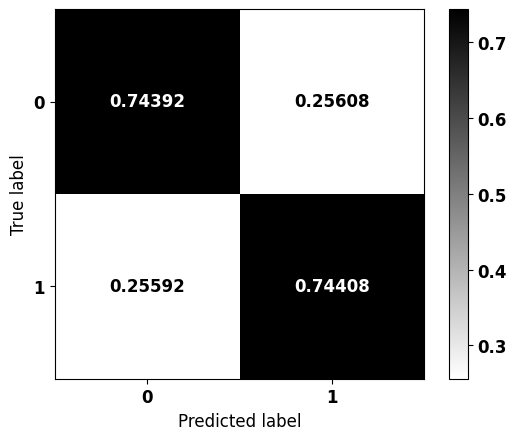


              precision    recall  f1-score   support

           0    0.80743   0.74392   0.77437      3534
           1    0.66826   0.74408   0.70413      2450

    accuracy                        0.74398      5984
   macro avg    0.73784   0.74400   0.73925      5984
weighted avg    0.75045   0.74398   0.74562      5984



In [13]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=5,
                      class_weight={0:1, 1:1.41},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train_boca, y_train_boca)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test_boca, y_test_boca)

#### **Optuna**

In [14]:
params = {'n_estimators': 68,
 'max_depth': 5,
 'learning_rate': 0.16,
 'min_child_weight': 5,
 'colsample_bytree': 0.5}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.4141}

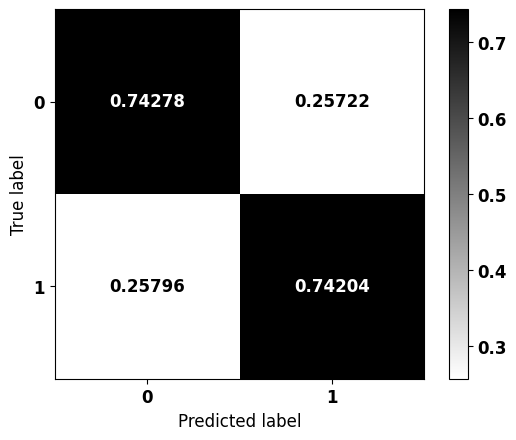


              precision    recall  f1-score   support

           0    0.80596   0.74278   0.77308      3534
           1    0.66667   0.74204   0.70234      2450

    accuracy                        0.74248      5984
   macro avg    0.73631   0.74241   0.73771      5984
weighted avg    0.74893   0.74248   0.74412      5984



In [15]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train_boca, y_train_boca)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test_boca, y_test_boca)

### **Melhor modelo**

In [16]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best_boca = m
    else:
        best_score = best_boca.score(X_test_boca, y_test_boca)
        score = m.score(X_test_boca, y_test_boca)
        if score > best_score:
            best_boca = m

print(best_boca)

LGBMClassifier(class_weight={0: 1, 1: 1.41}, max_depth=5, random_state=7,
               verbose=-1)


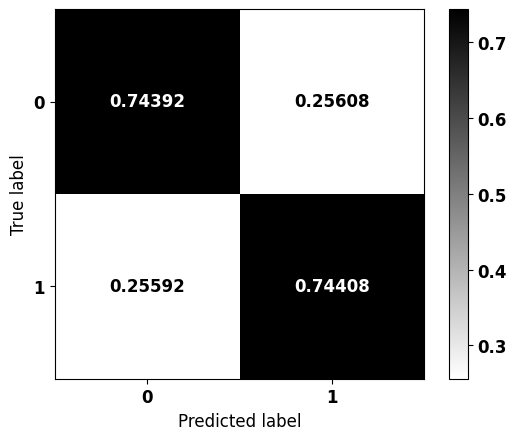


              precision    recall  f1-score   support

           0    0.80743   0.74392   0.77437      3534
           1    0.66826   0.74408   0.70413      2450

    accuracy                        0.74398      5984
   macro avg    0.73784   0.74400   0.73925      5984
weighted avg    0.75045   0.74398   0.74562      5984



In [17]:
# Matriz de confusão
plot_confusion_matrix(best_boca, X_test_boca, y_test_boca)

## **Orofaringe**

In [18]:
# Valores faltantes
df_oro.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [19]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_oro, X_test_oro, y_train_oro, y_test_oro, feat_cols, enc, norm = preprocessing(df_oro,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (3691, 23), X_test = (1231, 23)
y_train = (3691,), y_test = (1231,)


### **XGBoost**


#### **Modelo base**

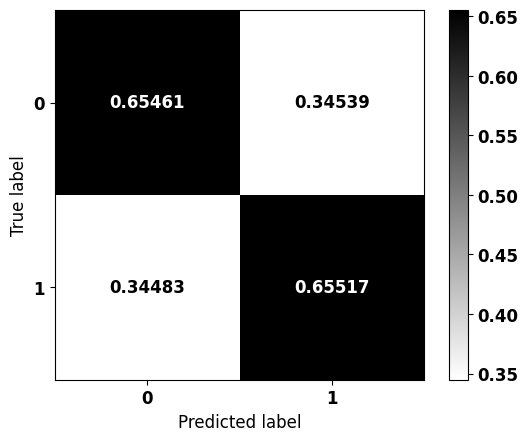


              precision    recall  f1-score   support

           0    0.84441   0.65461   0.73749       912
           1    0.39885   0.65517   0.49585       319

    accuracy                        0.65475      1231
   macro avg    0.62163   0.65489   0.61667      1231
weighted avg    0.72895   0.65475   0.67487      1231



In [20]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=2,
                    scale_pos_weight=2.849,
                    random_state=seed)

xgb.fit(X_train_oro, y_train_oro)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test_oro, y_test_oro)

#### **Optuna**

In [21]:
params = {'n_estimators': 94,
 'max_depth': 3,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 6,
 'colsample_bytree': 0.5}

params['random_state'] = seed
params['scale_pos_weight'] = 2.937

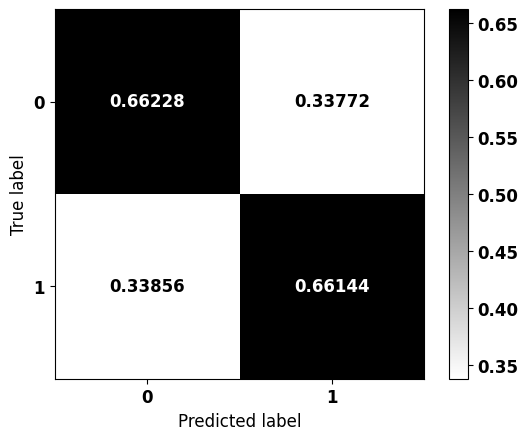


              precision    recall  f1-score   support

           0    0.84831   0.66228   0.74384       912
           1    0.40655   0.66144   0.50358       319

    accuracy                        0.66206      1231
   macro avg    0.62743   0.66186   0.62371      1231
weighted avg    0.73384   0.66206   0.68158      1231



In [22]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train_oro, y_train_oro)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test_oro, y_test_oro)

### **LightGBM**


#### **Modelo base**

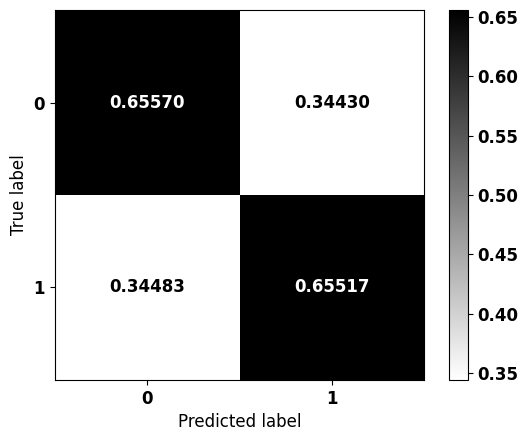


              precision    recall  f1-score   support

           0    0.84463   0.65570   0.73827       912
           1    0.39962   0.65517   0.49644       319

    accuracy                        0.65556      1231
   macro avg    0.62213   0.65544   0.61735      1231
weighted avg    0.72931   0.65556   0.67560      1231



In [23]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=2,
                      class_weight={0:1, 1:2.662},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train_oro, y_train_oro)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test_oro, y_test_oro)

#### **Optuna**

In [24]:
params = {'n_estimators': 79,
 'max_depth': 2,
 'learning_rate': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:2.748}

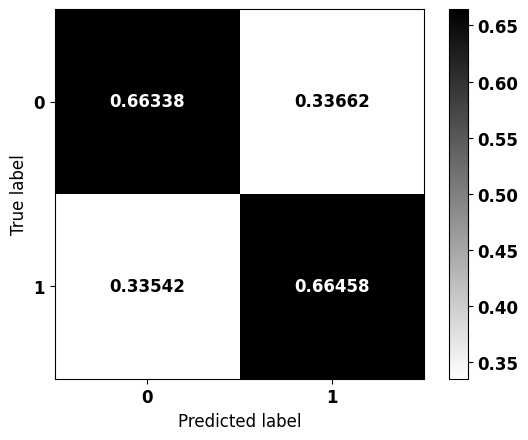


              precision    recall  f1-score   support

           0    0.84972   0.66338   0.74507       912
           1    0.40848   0.66458   0.50597       319

    accuracy                        0.66369      1231
   macro avg    0.62910   0.66398   0.62552      1231
weighted avg    0.73538   0.66369   0.68311      1231



In [25]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train_oro, y_train_oro)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test_oro, y_test_oro)

### **Melhor modelo**

In [26]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best_oro = m
    else:
        best_score = best_oro.score(X_test_oro, y_test_oro)
        score = m.score(X_test_oro, y_test_oro)
        if score > best_score:
            best_oro = m

print(best_oro)

LGBMClassifier(class_weight={0: 1, 1: 2.748}, colsample_bytree=0.4,
               learning_rate=0.2, max_depth=2, min_child_weight=6,
               n_estimators=79, random_state=7, verbose=-1)


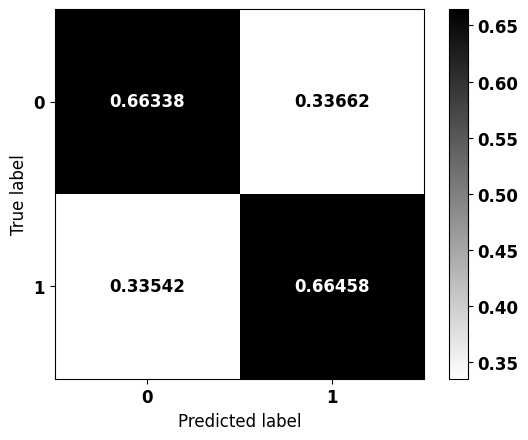


              precision    recall  f1-score   support

           0    0.84972   0.66338   0.74507       912
           1    0.40848   0.66458   0.50597       319

    accuracy                        0.66369      1231
   macro avg    0.62910   0.66398   0.62552      1231
weighted avg    0.73538   0.66369   0.68311      1231



In [27]:
# Matriz de confusão
plot_confusion_matrix(best_oro, X_test_oro, y_test_oro)

## **Esôfago**

In [28]:
# Valores faltantes
df_eso.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [29]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_eso, X_test_eso, y_train_eso, y_test_eso, feat_cols, enc, norm = preprocessing(df_eso,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (10470, 23), X_test = (3491, 23)
y_train = (10470,), y_test = (3491,)


### **XGBoost**


#### **Modelo base**

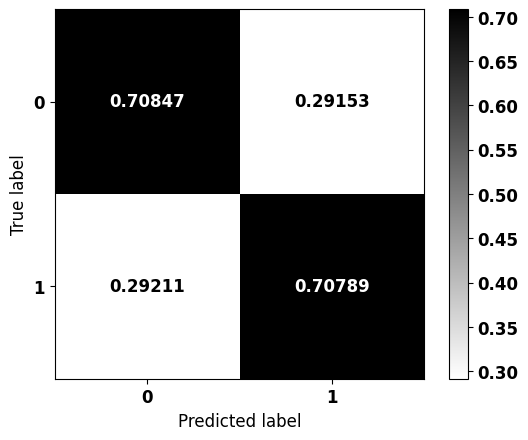


              precision    recall  f1-score   support

           0    0.93986   0.70847   0.80792      3022
           1    0.27370   0.70789   0.39477       469

    accuracy                        0.70839      3491
   macro avg    0.60678   0.70818   0.60135      3491
weighted avg    0.85036   0.70839   0.75242      3491



In [30]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=2,
                    scale_pos_weight=6.62,
                    random_state=seed)

xgb.fit(X_train_eso, y_train_eso)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test_eso, y_test_eso)

#### **Optuna**

In [31]:
params = {'n_estimators': 131,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'min_child_weight': 4,
 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 6.426

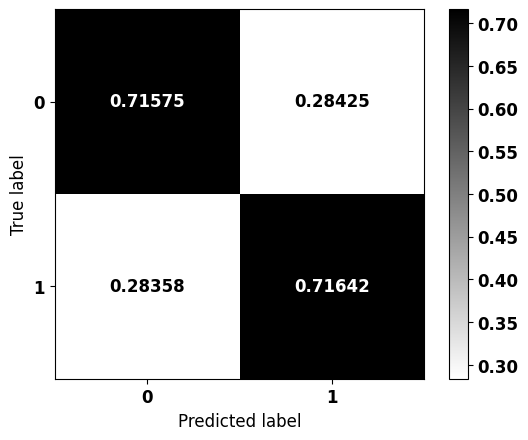


              precision    recall  f1-score   support

           0    0.94207   0.71575   0.81346      3022
           1    0.28117   0.71642   0.40385       469

    accuracy                        0.71584      3491
   macro avg    0.61162   0.71608   0.60865      3491
weighted avg    0.85328   0.71584   0.75843      3491



In [32]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train_eso, y_train_eso)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test_eso, y_test_eso)

### **LightGBM**


#### **Modelo base**

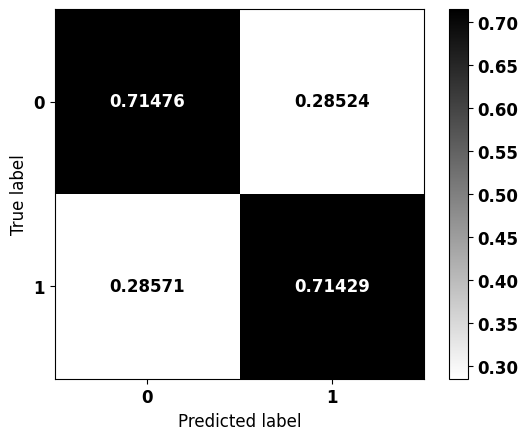


              precision    recall  f1-score   support

           0    0.94159   0.71476   0.81264      3022
           1    0.27987   0.71429   0.40216       469

    accuracy                        0.71469      3491
   macro avg    0.61073   0.71452   0.60740      3491
weighted avg    0.85269   0.71469   0.75749      3491



In [33]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=2,
                      class_weight={0:1, 1:6.2},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train_eso, y_train_eso)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test_eso, y_test_eso)

#### **Optuna**

In [34]:
params = {'n_estimators': 94,
 'max_depth': 3,
 'learning_rate': 0.12,
 'min_child_weight': 4,
 'colsample_bytree': 0.6}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:6.488}

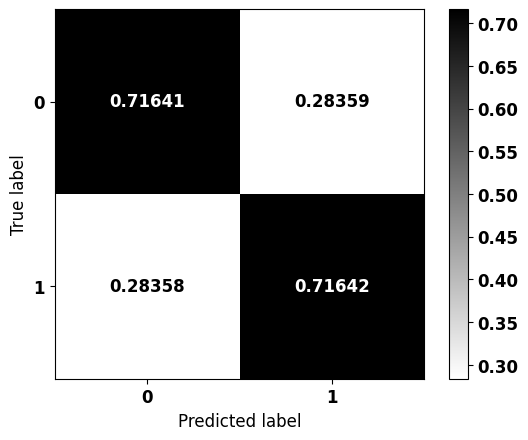


              precision    recall  f1-score   support

           0    0.94212   0.71641   0.81391      3022
           1    0.28164   0.71642   0.40433       469

    accuracy                        0.71641      3491
   macro avg    0.61188   0.71642   0.60912      3491
weighted avg    0.85339   0.71641   0.75888      3491



In [35]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train_eso, y_train_eso)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test_eso, y_test_eso)

### **Melhor modelo**

In [36]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best_eso = m
    else:
        best_score = best_eso.score(X_test_eso, y_test_eso)
        score = m.score(X_test_eso, y_test_eso)
        if score > best_score:
            best_eso = m

print(best_eso)

LGBMClassifier(class_weight={0: 1, 1: 6.488}, colsample_bytree=0.6,
               learning_rate=0.12, max_depth=3, min_child_weight=4,
               n_estimators=94, random_state=7, verbose=-1)


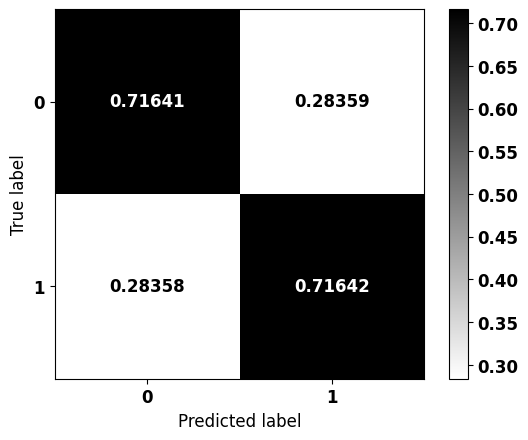


              precision    recall  f1-score   support

           0    0.94212   0.71641   0.81391      3022
           1    0.28164   0.71642   0.40433       469

    accuracy                        0.71641      3491
   macro avg    0.61188   0.71642   0.60912      3491
weighted avg    0.85339   0.71641   0.75888      3491



In [37]:
# Matriz de confusão
plot_confusion_matrix(best_eso, X_test_eso, y_test_eso)

## **Estômago**

In [38]:
# Valores faltantes
df_esto.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [39]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_esto, X_test_esto, y_train_esto, y_test_esto, feat_cols, enc, norm = preprocessing(df_esto,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (20827, 23), X_test = (6943, 23)
y_train = (20827,), y_test = (6943,)


### **XGBoost**


#### **Modelo base**

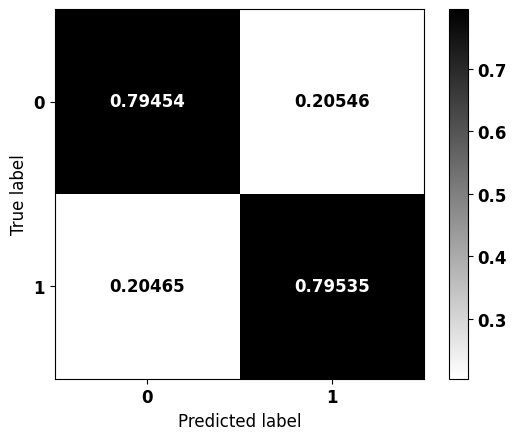


              precision    recall  f1-score   support

           0    0.91207   0.79454   0.84925      5052
           1    0.59166   0.79535   0.67855      1891

    accuracy                        0.79476      6943
   macro avg    0.75186   0.79494   0.76390      6943
weighted avg    0.82480   0.79476   0.80276      6943



In [40]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=3,
                    scale_pos_weight=2.325,
                    random_state=seed)

xgb.fit(X_train_esto, y_train_esto)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test_esto, y_test_esto)

#### **Optuna**

In [41]:
params = {'n_estimators': 70,
 'max_depth': 5,
 'learning_rate': 0.15,
 'gamma': 0.2,
 'min_child_weight': 7,
 'colsample_bytree': 0.6}

params['random_state'] = seed
params['scale_pos_weight'] = 2.403

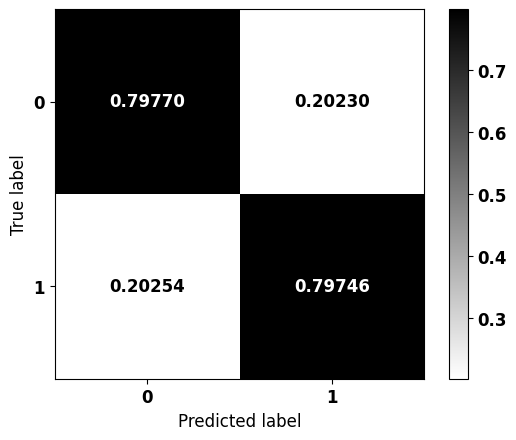


              precision    recall  f1-score   support

           0    0.91321   0.79770   0.85156      5052
           1    0.59605   0.79746   0.68220      1891

    accuracy                        0.79764      6943
   macro avg    0.75463   0.79758   0.76688      6943
weighted avg    0.82683   0.79764   0.80543      6943



In [42]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train_esto, y_train_esto)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test_esto, y_test_esto)

### **LightGBM**


#### **Modelo base**

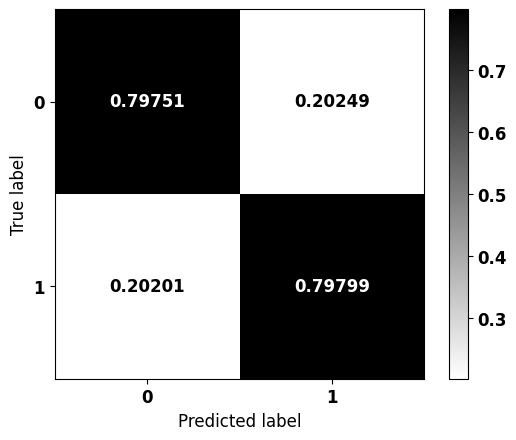


              precision    recall  f1-score   support

           0    0.91340   0.79751   0.85153      5052
           1    0.59597   0.79799   0.68234      1891

    accuracy                        0.79764      6943
   macro avg    0.75468   0.79775   0.76693      6943
weighted avg    0.82694   0.79764   0.80545      6943



In [43]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=5,
                      class_weight={0:1, 1:2.34},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train_esto, y_train_esto)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test_esto, y_test_esto)

#### **Optuna**

In [44]:
params = {'n_estimators': 150,
 'max_depth': 4,
 'learning_rate': 0.12,
 'min_child_weight': 3,
 'colsample_bytree': 0.7}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:2.422}

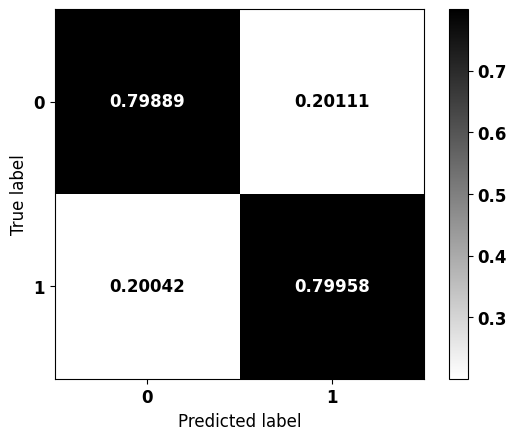


              precision    recall  f1-score   support

           0    0.91416   0.79889   0.85265      5052
           1    0.59810   0.79958   0.68432      1891

    accuracy                        0.79908      6943
   macro avg    0.75613   0.79923   0.76848      6943
weighted avg    0.82808   0.79908   0.80680      6943



In [45]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train_esto, y_train_esto)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test_esto, y_test_esto)

### **Melhor modelo**

In [46]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best_esto = m
    else:
        best_score = best_esto.score(X_test_esto, y_test_esto)
        score = m.score(X_test_esto, y_test_esto)
        if score > best_score:
            best_esto = m

print(best_esto)

LGBMClassifier(class_weight={0: 1, 1: 2.422}, colsample_bytree=0.7,
               learning_rate=0.12, max_depth=4, min_child_weight=3,
               n_estimators=150, random_state=7, verbose=-1)


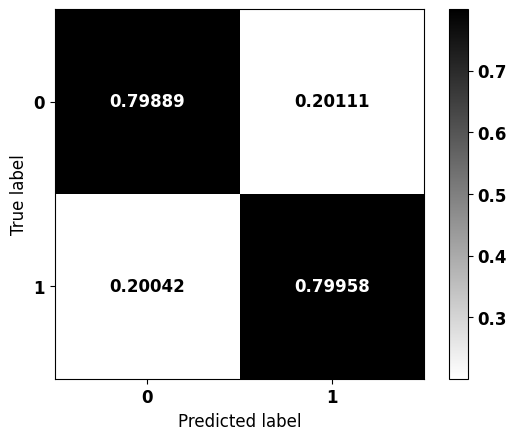


              precision    recall  f1-score   support

           0    0.91416   0.79889   0.85265      5052
           1    0.59810   0.79958   0.68432      1891

    accuracy                        0.79908      6943
   macro avg    0.75613   0.79923   0.76848      6943
weighted avg    0.82808   0.79908   0.80680      6943



In [47]:
# Matriz de confusão
plot_confusion_matrix(best_esto, X_test_esto, y_test_esto)

## **Intestino Delgado**

In [48]:
# Valores faltantes
df_delg.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [49]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_delg, X_test_delg, y_train_delg, y_test_delg, feat_cols, enc, norm = preprocessing(df_delg,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (1195, 23), X_test = (399, 23)
y_train = (1195,), y_test = (399,)


### **XGBoost**


#### **Modelo base**

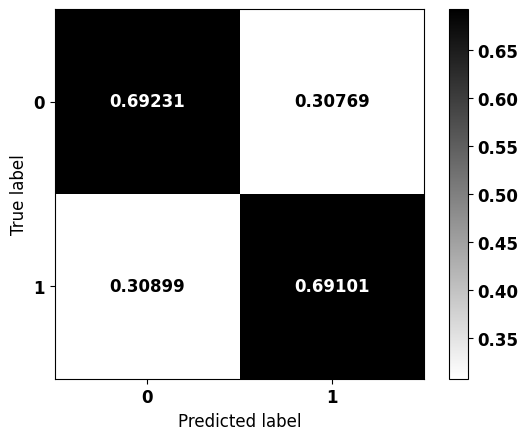


              precision    recall  f1-score   support

           0    0.73558   0.69231   0.71329       221
           1    0.64398   0.69101   0.66667       178

    accuracy                        0.69173       399
   macro avg    0.68978   0.69166   0.68998       399
weighted avg    0.69471   0.69173   0.69249       399



In [50]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=2,
                    n_estimators=50,
                    scale_pos_weight=1.1,
                    random_state=seed)

xgb.fit(X_train_delg, y_train_delg)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test_delg, y_test_delg)

#### **Optuna**

In [51]:
params = {'n_estimators': 74,
 'max_depth': 3,
 'learning_rate': 0.15,
 'gamma': 0.2,
 'min_child_weight': 1,
 'colsample_bytree': 0.3}

params['random_state'] = seed
params['scale_pos_weight'] = 1.126

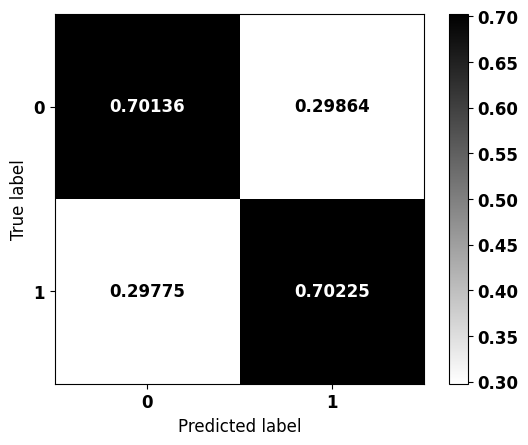


              precision    recall  f1-score   support

           0    0.74519   0.70136   0.72261       221
           1    0.65445   0.70225   0.67751       178

    accuracy                        0.70175       399
   macro avg    0.69982   0.70180   0.70006       399
weighted avg    0.70471   0.70175   0.70249       399



In [52]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train_delg, y_train_delg)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test_delg, y_test_delg)

### **LightGBM**


#### **Modelo base**

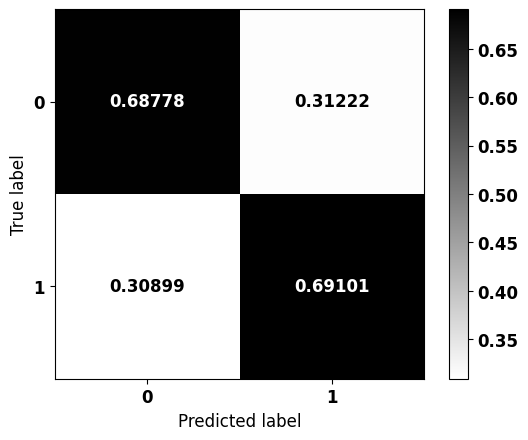


              precision    recall  f1-score   support

           0    0.73430   0.68778   0.71028       221
           1    0.64062   0.69101   0.66486       178

    accuracy                        0.68922       399
   macro avg    0.68746   0.68940   0.68757       399
weighted avg    0.69251   0.68922   0.69002       399



In [53]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=2,
                      n_estimators=50,
                      class_weight={0:1, 1:1.1041},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train_delg, y_train_delg)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test_delg, y_test_delg)

#### **Optuna**

In [54]:
params = {'n_estimators': 67,
 'max_depth': 3,
 'learning_rate': 0.14,
 'min_child_weight': 2,
 'colsample_bytree': 0.6}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.048}

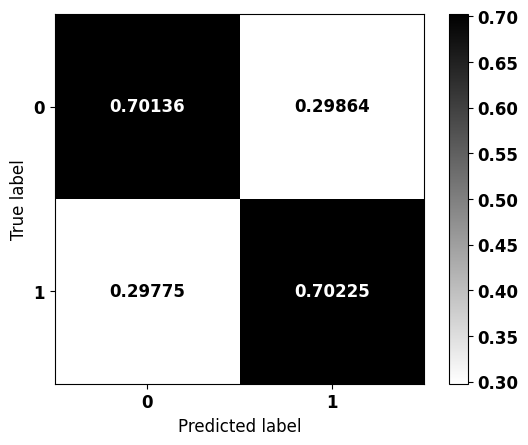


              precision    recall  f1-score   support

           0    0.74519   0.70136   0.72261       221
           1    0.65445   0.70225   0.67751       178

    accuracy                        0.70175       399
   macro avg    0.69982   0.70180   0.70006       399
weighted avg    0.70471   0.70175   0.70249       399



In [55]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train_delg, y_train_delg)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test_delg, y_test_delg)

### **Melhor modelo**

In [56]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best_delg = m
    else:
        best_score = best_delg.score(X_test_delg, y_test_delg)
        score = m.score(X_test_delg, y_test_delg)
        if score > best_score:
            best_delg = m

print(best_delg)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=74, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


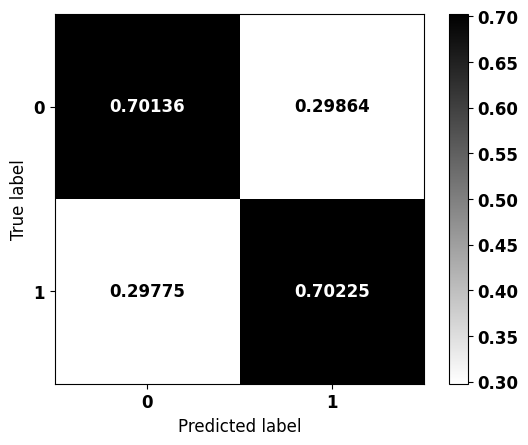


              precision    recall  f1-score   support

           0    0.74519   0.70136   0.72261       221
           1    0.65445   0.70225   0.67751       178

    accuracy                        0.70175       399
   macro avg    0.69982   0.70180   0.70006       399
weighted avg    0.70471   0.70175   0.70249       399



In [57]:
# Matriz de confusão
plot_confusion_matrix(best_delg, X_test_delg, y_test_delg)

## **Colorretal**

In [58]:
# Valores faltantes
df_colo.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [59]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_colo, X_test_colo, y_train_colo, y_test_colo, feat_cols, enc, norm = preprocessing(df_colo,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (42083, 23), X_test = (14028, 23)
y_train = (42083,), y_test = (14028,)


### **XGBoost**


#### **Modelo base**

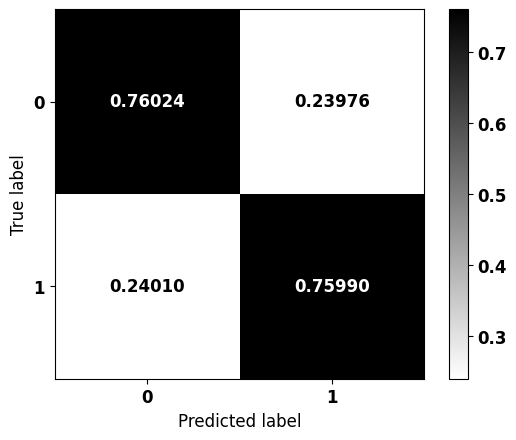


              precision    recall  f1-score   support

           0    0.71920   0.76024   0.73915      6273
           1    0.79667   0.75990   0.77785      7755

    accuracy                        0.76005     14028
   macro avg    0.75794   0.76007   0.75850     14028
weighted avg    0.76203   0.76005   0.76055     14028



In [60]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=4,
                    scale_pos_weight=0.645,
                    random_state=seed)

xgb.fit(X_train_colo, y_train_colo)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test_colo, y_test_colo)

#### **Optuna**

In [61]:
params = {'n_estimators': 107,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'min_child_weight': 5,
 'colsample_bytree': 0.6}

params['random_state'] = seed
params['scale_pos_weight'] = 0.6488

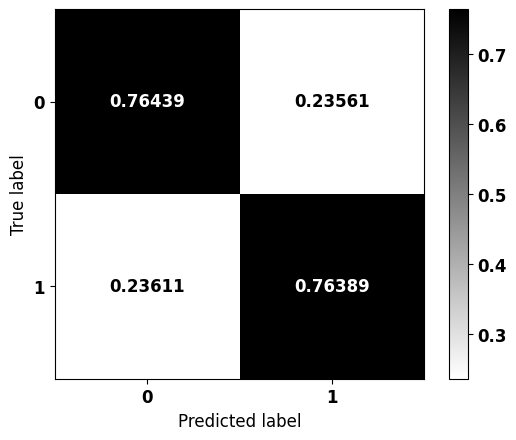


              precision    recall  f1-score   support

           0    0.72366   0.76439   0.74347      6273
           1    0.80032   0.76389   0.78169      7755

    accuracy                        0.76411     14028
   macro avg    0.76199   0.76414   0.76258     14028
weighted avg    0.76604   0.76411   0.76460     14028



In [62]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train_colo, y_train_colo)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test_colo, y_test_colo)

### **LightGBM**


#### **Modelo base**

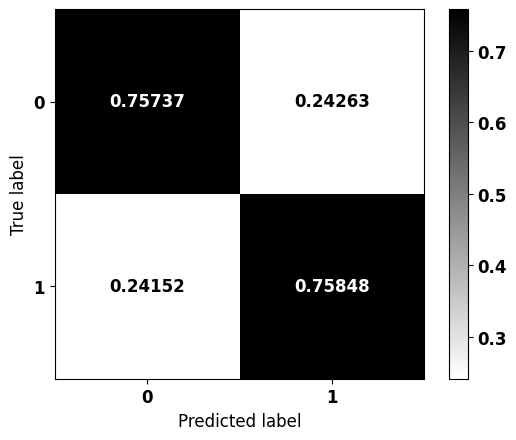


              precision    recall  f1-score   support

           0    0.71724   0.75737   0.73676      6273
           1    0.79444   0.75848   0.77604      7755

    accuracy                        0.75798     14028
   macro avg    0.75584   0.75793   0.75640     14028
weighted avg    0.75992   0.75798   0.75848     14028



In [63]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0: 1.4662, 1: 1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train_colo, y_train_colo)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test_colo, y_test_colo)

#### **Optuna**

In [64]:
params = {'n_estimators': 143,
 'max_depth': 10,
 'learning_rate': 0.12,
 'min_child_weight': 1,
 'colsample_bytree': 0.5}

params['random_state'] = seed
params['class_weight'] = {0:1.4445, 1:1}

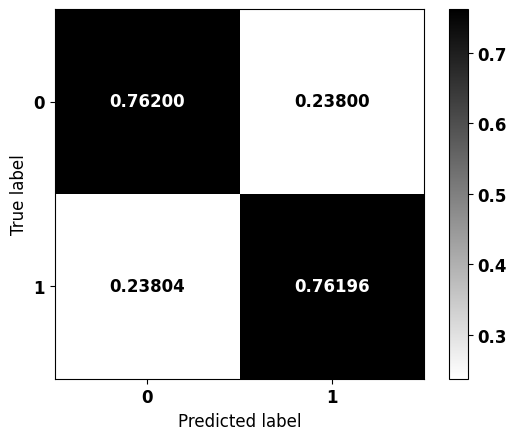


              precision    recall  f1-score   support

           0    0.72140   0.76200   0.74114      6273
           1    0.79830   0.76196   0.77971      7755

    accuracy                        0.76198     14028
   macro avg    0.75985   0.76198   0.76042     14028
weighted avg    0.76391   0.76198   0.76246     14028



In [65]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train_colo, y_train_colo)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test_colo, y_test_colo)

### **Melhor modelo**

In [66]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best_colo = m
    else:
        best_score = best_colo.score(X_test_colo, y_test_colo)
        score = m.score(X_test_colo, y_test_colo)
        if score > best_score:
            best_colo = m

print(best_colo)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=107, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


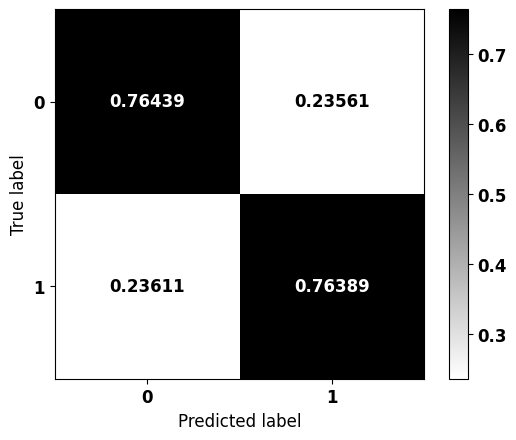


              precision    recall  f1-score   support

           0    0.72366   0.76439   0.74347      6273
           1    0.80032   0.76389   0.78169      7755

    accuracy                        0.76411     14028
   macro avg    0.76199   0.76414   0.76258     14028
weighted avg    0.76604   0.76411   0.76460     14028



In [67]:
# Matriz de confusão
plot_confusion_matrix(best_colo, X_test_colo, y_test_colo)

## **Ânus**

In [68]:
# Valores faltantes
df_anus.isna().sum().sort_values(ascending=False).head(6)

IDADE             0
SEXO              0
sobrevida_ano3    0
sobrevida_ano1    0
obito_geral       0
presenca_rec      0
dtype: int64

In [69]:
# Dados pré-processados
list_drop = ['TRATHOSP', 'TOPO', 'TOPOGRUP', 'NENHUM', 'TRATCONS', 'obito_geral',
             'sobrevida_ano1', 'sobrevida_ano5']

lb = 'sobrevida_ano3'

X_train_anus, X_test_anus, y_train_anus, y_test_anus, feat_cols, enc, norm = preprocessing(df_anus,
                                                                       list_drop, lb,
                                                                       norm_name='StandardScaler',
                                                                       return_enc_norm=True,
                                                                       random_state=seed)

X_train = (1707, 23), X_test = (569, 23)
y_train = (1707,), y_test = (569,)


### **XGBoost**


#### **Modelo base**

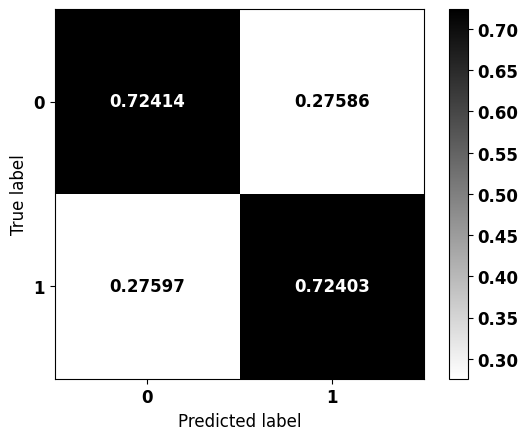


              precision    recall  f1-score   support

           0    0.68978   0.72414   0.70654       261
           1    0.75593   0.72403   0.73964       308

    accuracy                        0.72408       569
   macro avg    0.72286   0.72408   0.72309       569
weighted avg    0.72559   0.72408   0.72446       569



In [70]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=2,
                    scale_pos_weight=0.745,
                    random_state=seed)

xgb.fit(X_train_anus, y_train_anus)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test_anus, y_test_anus)

#### **Optuna**

In [71]:
params = {'n_estimators': 80,
 'max_depth': 3,
 'learning_rate': 0.15,
 'gamma': 0.0,
 'min_child_weight': 7,
 'colsample_bytree': 0.7}

params['random_state'] = seed
params['scale_pos_weight'] = 0.7322

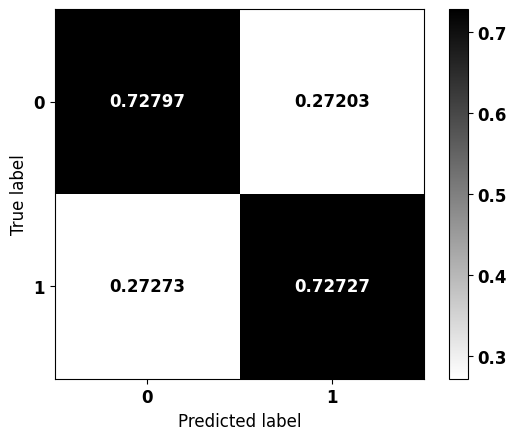


              precision    recall  f1-score   support

           0    0.69343   0.72797   0.71028       261
           1    0.75932   0.72727   0.74295       308

    accuracy                        0.72759       569
   macro avg    0.72638   0.72762   0.72662       569
weighted avg    0.72910   0.72759   0.72797       569



In [72]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train_anus, y_train_anus)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test_anus, y_test_anus)

### **LightGBM**


#### **Modelo base**

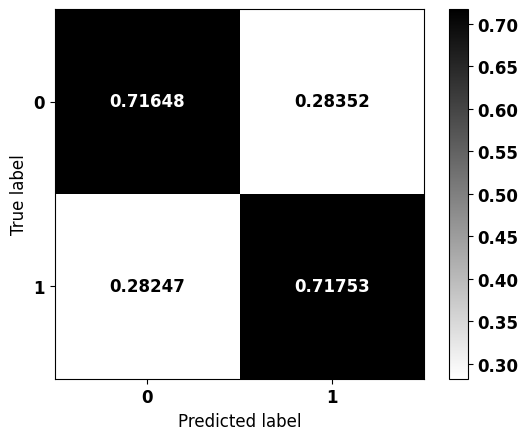


              precision    recall  f1-score   support

           0    0.68248   0.71648   0.69907       261
           1    0.74915   0.71753   0.73300       308

    accuracy                        0.71705       569
   macro avg    0.71582   0.71700   0.71603       569
weighted avg    0.71857   0.71705   0.71744       569



In [73]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=3,
                      class_weight={0:1.418, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train_anus, y_train_anus)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test_anus, y_test_anus)

#### **Optuna**

In [74]:
params = {'n_estimators': 97,
 'max_depth': 2,
 'learning_rate': 0.15,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}


params['random_state'] = seed
params['class_weight'] = {0:1.44, 1:1}

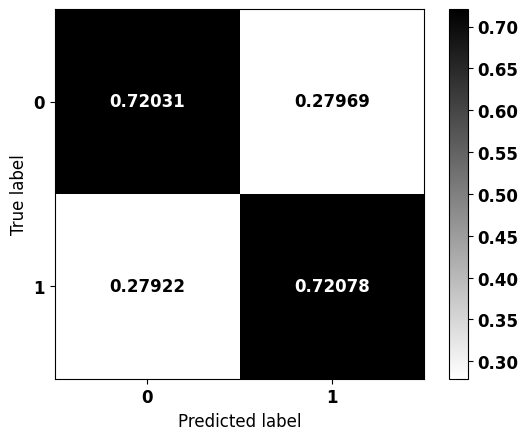


              precision    recall  f1-score   support

           0    0.68613   0.72031   0.70280       261
           1    0.75254   0.72078   0.73632       308

    accuracy                        0.72056       569
   macro avg    0.71934   0.72054   0.71956       569
weighted avg    0.72208   0.72056   0.72095       569



In [75]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train_anus, y_train_anus)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test_anus, y_test_anus)

### **Melhor modelo**

In [76]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best_anus = m
    else:
        best_score = best_anus.score(X_test_anus, y_test_anus)
        score = m.score(X_test_anus, y_test_anus)
        if score > best_score:
            best_anus = m

print(best_anus)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


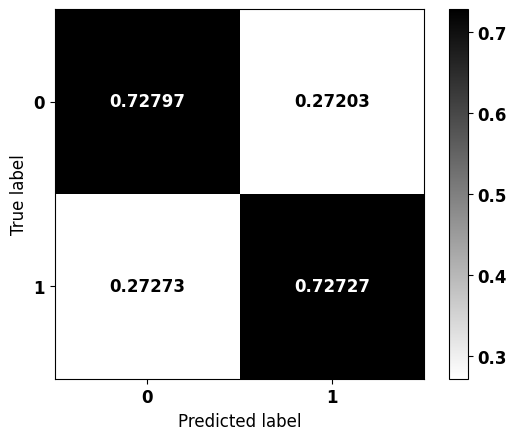


              precision    recall  f1-score   support

           0    0.69343   0.72797   0.71028       261
           1    0.75932   0.72727   0.74295       308

    accuracy                        0.72759       569
   macro avg    0.72638   0.72762   0.72662       569
weighted avg    0.72910   0.72759   0.72797       569



In [77]:
# Matriz de confusão
plot_confusion_matrix(best_anus, X_test_anus, y_test_anus)

## **Grade de matrizes de confusão**

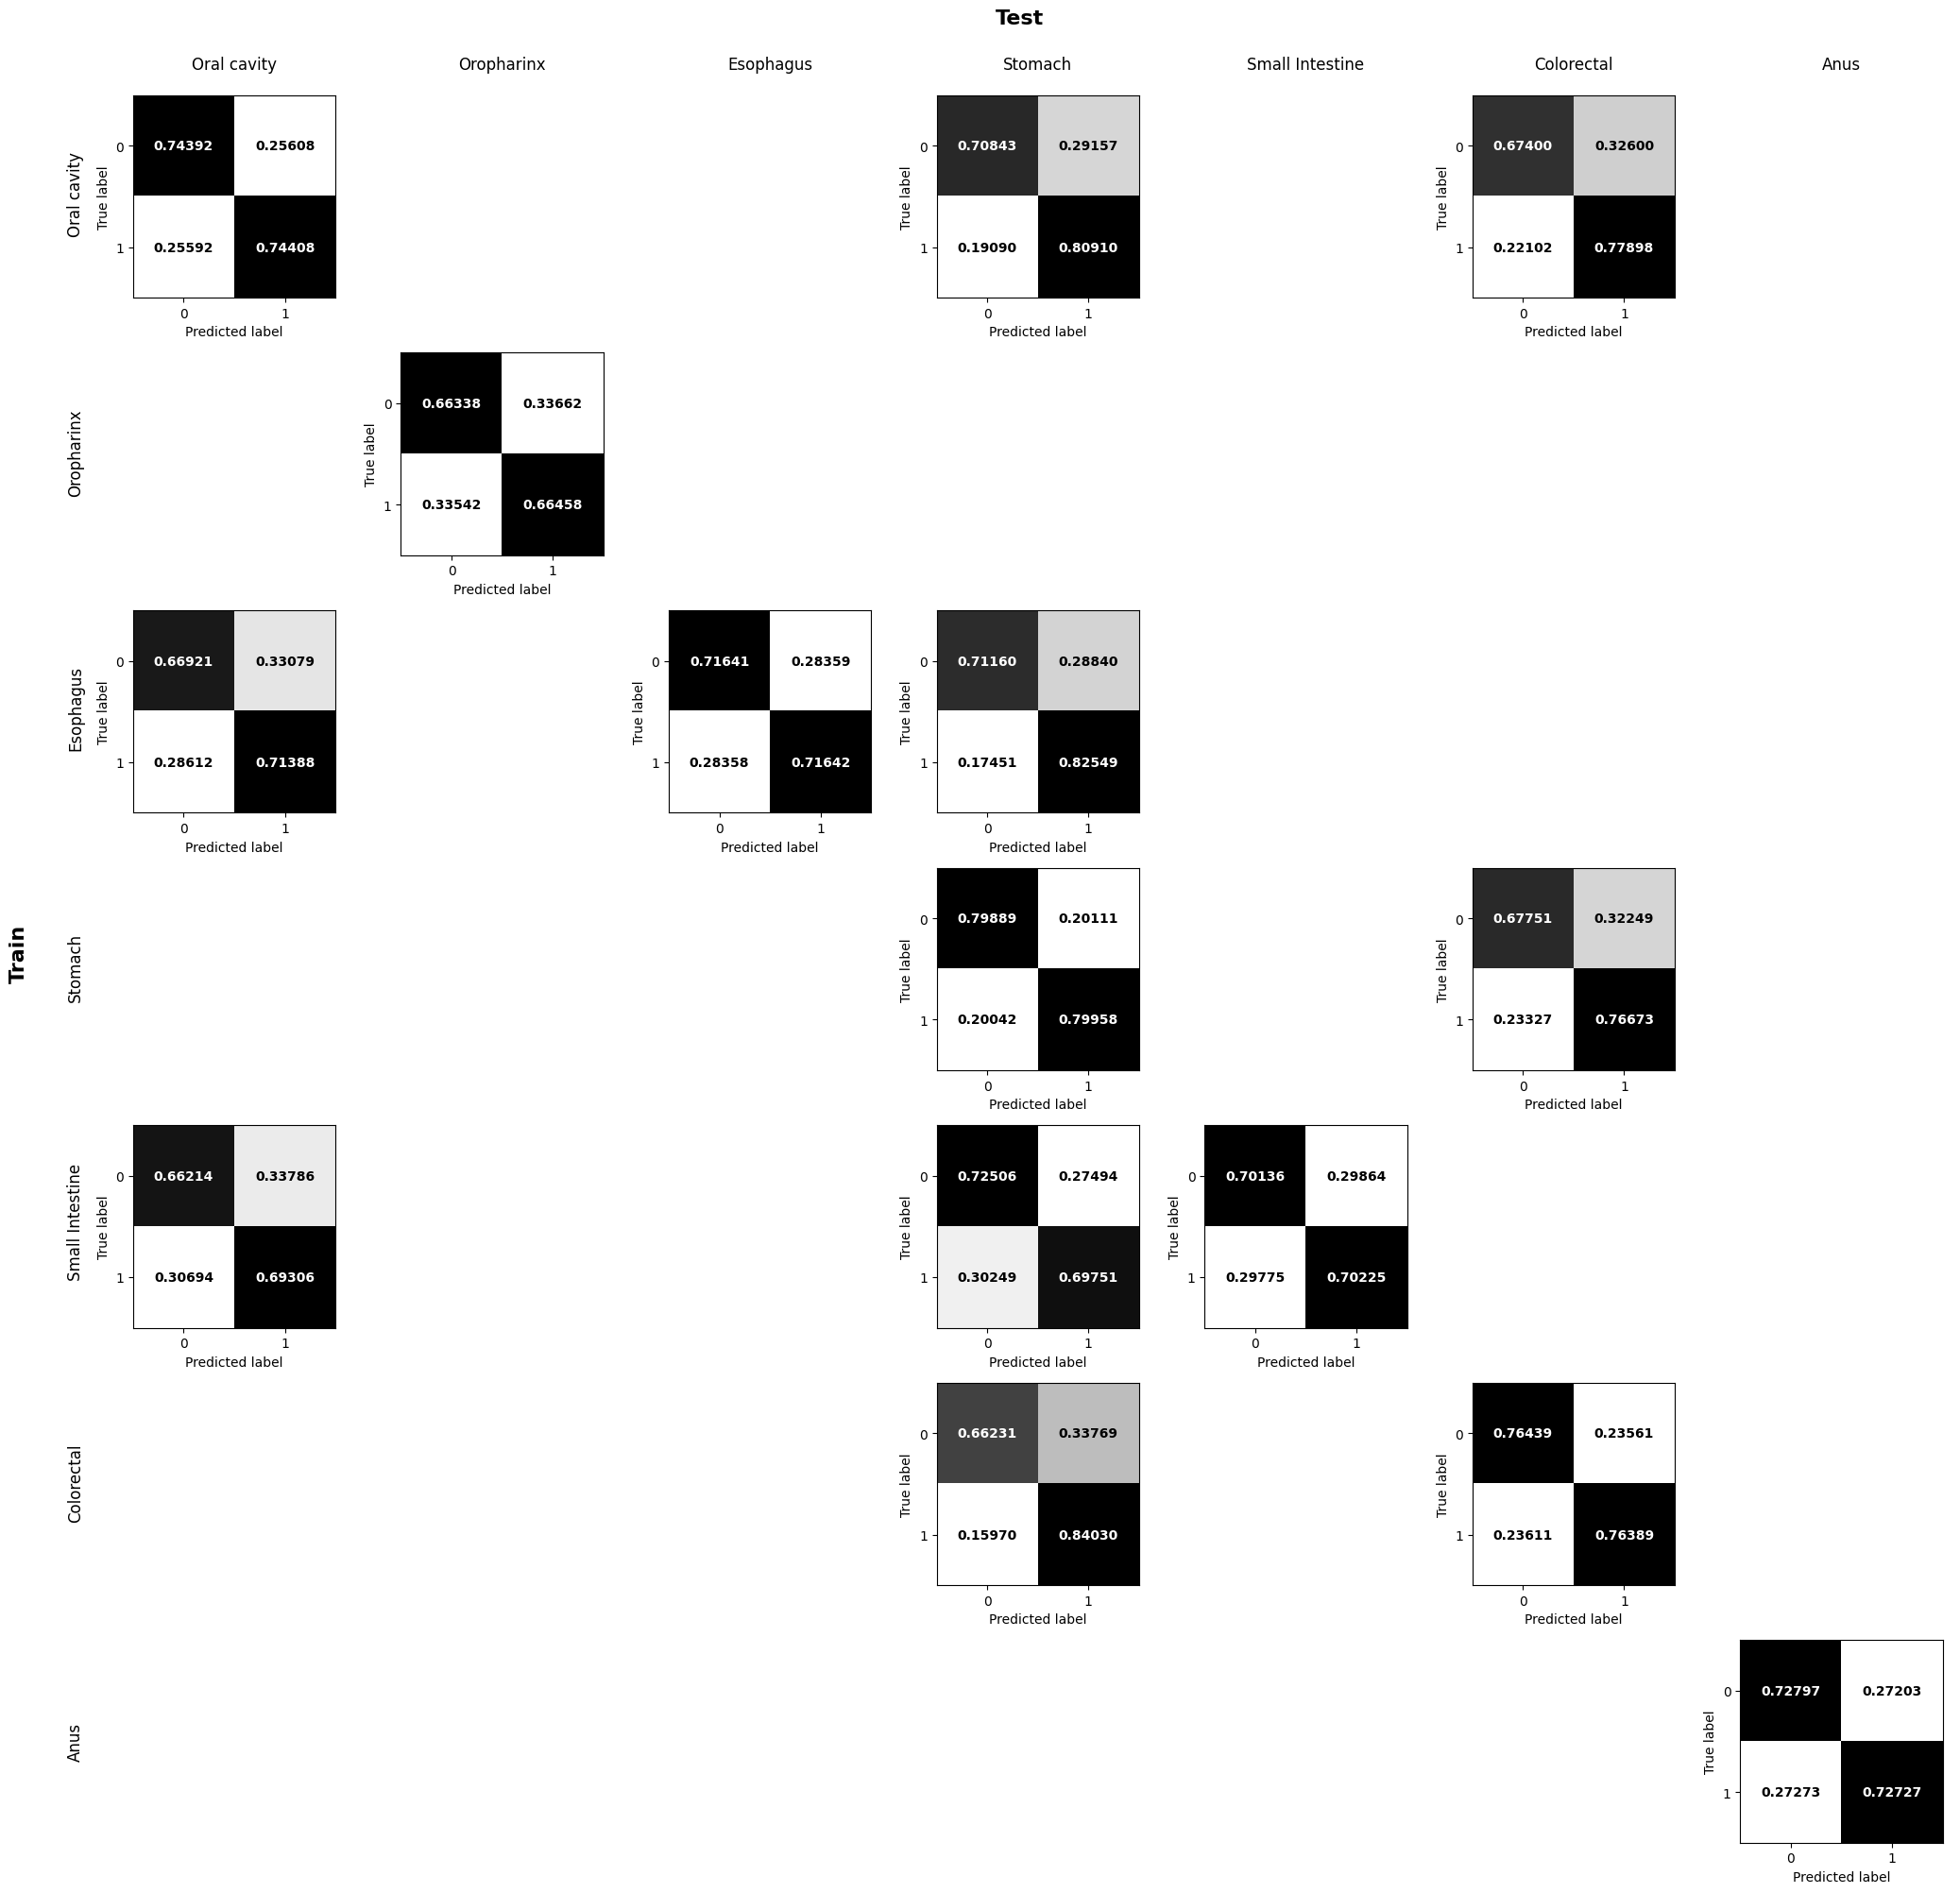

In [78]:
import matplotlib.pyplot as plt

# Títulos gerais
title_general_columns = 'Test'
title_general_rows = 'Train'

# Títulos das colunas e linhas
titles = ['Oral cavity', 'Oropharinx', 'Esophagus', 'Stomach',
          'Small Intestine', 'Colorectal', 'Anus']

# Índices das posições a serem preenchidas com matrizes de confusão
positions_to_fill = {0: (best_boca, X_test_boca, y_test_boca),
                     3: (best_boca, X_test_esto, y_test_esto),
                     5: (best_boca, X_test_colo, y_test_colo),
                     8: (best_oro, X_test_oro, y_test_oro),
                     14: (best_eso, X_test_boca, y_test_boca),
                     16: (best_eso, X_test_eso, y_test_eso),
                     17: (best_eso, X_test_esto, y_test_esto),
                     24: (best_esto, X_test_esto, y_test_esto),
                     26: (best_esto, X_test_colo, y_test_colo),
                     28: (best_delg, X_test_boca, y_test_boca),
                     31: (best_delg, X_test_esto, y_test_esto),
                     32: (best_delg, X_test_delg, y_test_delg),
                     38: (best_colo, X_test_esto, y_test_esto),
                     40: (best_colo, X_test_colo, y_test_colo),
                     48: (best_anus, X_test_anus, y_test_anus)}

position = [0.902, 0.765, 0.6302, 0.493, 0.358, 0.22, 0.083]

# Configuração da figura com 7 linhas e 7 colunas
fig, axes = plt.subplots(7, 7, figsize=(20, 20))

for i, ax in enumerate(axes.flatten()):

    if i in positions_to_fill.keys():
        plot_confusion_matrix_v2(positions_to_fill[i][0], positions_to_fill[i][1],
                                 positions_to_fill[i][2], ax=ax)
    else:
        # Deixe as posições não especificadas em branco
        ax.axis('off')

# Adiciona títulos das colunas
for col_idx in range(7):
    axes[0, col_idx].set_title(titles[col_idx], fontsize=12, pad=20)

# Adiciona títulos das linhas
for row_idx in range(7):
    fig.text(0, position[row_idx], titles[row_idx], va='center',
             ha='center', rotation='vertical', fontsize=12)  # Ajuste o valor de x conforme necessário

# Adiciona título geral para as colunas
fig.suptitle(title_general_columns, fontsize=16, y=1, weight='bold')

# Adiciona título geral para as linhas
fig.text(-0.03, 0.5, title_general_rows, va='center', ha='center',
         rotation='vertical', fontsize=16, weight='bold')  # Ajuste o valor de x conforme necessário

# Ajuste dos espaços entre os subplots
plt.tight_layout()
plt.savefig(figures_path+'/digest.eps', bbox_inches='tight')

# **Conexões**

In [ ]:
%%capture

!gdown 129xV7F8XXr_4PqRtcR-GV7unEgNrL6qW --quiet # Sistema Digestório treino
!gdown 13aJGpxw_tAhT-44yuD-mRKjDsJcHwynU --quiet # Sistema Digestório teste

In [ ]:
df_sist_dig_treino = pd.read_csv('/content/sist_dig_treino.csv')
print(df_sist_dig_treino.shape)
df_sist_dig_treino.head(3)

(97924, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,-0.313399,-0.486452,0.889193,-0.855087,-0.933936,-0.777605,-1.053163,-1.057999,-0.846260,-0.052318,...,-0.702199,1.584652,0.669012,0.801956,-1.240717,0.520496,1.131402,2.122043,Boca,1
1,-0.775695,1.028664,0.875829,1.343451,-1.043802,1.054160,0.600930,-0.567847,-1.356322,-0.078540,...,-0.209650,-0.933152,-0.753735,0.794255,-0.968850,0.154944,0.964441,-0.475073,Colorretal,0
2,-0.815064,-0.486452,0.918482,-0.855087,1.070737,1.139022,-1.053163,0.945180,1.181669,-0.052318,...,0.732225,-0.949295,-0.763297,0.830259,0.464651,-1.748979,1.131402,-0.471244,Boca,0


In [ ]:
df_sist_dig_teste = pd.read_csv('/content/sist_dig_teste.csv')
print(df_sist_dig_teste.shape)
df_sist_dig_teste.head(3)

(32645, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.214492,1.028664,0.916336,1.343451,0.958036,1.054160,-1.664088,-0.567847,0.737288,-0.078540,...,-1.353129,-0.392930,-0.518012,0.692936,-0.968850,-0.870779,-1.036870,-0.475073,Colorretal,0
1,0.765536,-0.438574,0.929651,-0.867646,0.756823,0.008932,-0.545489,-1.026325,-1.178694,-0.053606,...,1.263874,-0.949246,-0.790110,0.836351,-1.175867,-1.674465,1.112286,-0.399978,Esôfago,0
2,0.773540,-0.486452,0.545758,1.148151,1.070737,-0.298449,-1.053163,0.945180,1.181669,-0.052318,...,-1.598714,0.679671,1.146449,-0.486755,-1.240717,-0.614241,-0.883859,-0.471244,Boca,1


In [ ]:
df_sist_dig_treino.TOPOGRUP.value_counts()

TOPOGRUP
Colorretal    42083
Estômago      20827
Boca          17951
Esôfago       10470
Orofaringe     3691
Ânus           1707
Delgado        1195
Name: count, dtype: int64

In [ ]:
um = ['Boca', 'Estômago', 'Colorretal']
dois = ['Esôfago', 'Boca', 'Estômago']
tres = ['Estômago', 'Colorretal']
quatro = ['Delgado', 'Boca', 'Estômago']

df1_treino = df_sist_dig_treino[df_sist_dig_treino.TOPOGRUP.isin(um)]
df1_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP.isin(um)]

df2_treino = df_sist_dig_treino[df_sist_dig_treino.TOPOGRUP.isin(dois)]
df2_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP.isin(dois)]

df3_treino = df_sist_dig_treino[df_sist_dig_treino.TOPOGRUP.isin(tres)]
df3_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP.isin(tres)]

df4_treino = df_sist_dig_treino[df_sist_dig_treino.TOPOGRUP.isin(quatro)]
df4_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP.isin(quatro)]

df1_treino.shape, df1_teste.shape, df2_treino.shape, df2_teste.shape, df3_treino.shape, df3_teste.shape, df4_treino.shape, df4_teste.shape

((80861, 25),
 (26955, 25),
 (49248, 25),
 (16418, 25),
 (62910, 25),
 (20971, 25),
 (39973, 25),
 (13326, 25))

In [ ]:
# DFs de teste para cada tipo
boca_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Boca']
eso_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Esôfago']
esto_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Estômago']
delg_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Delgado']
colo_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Colorretal']

boca_teste.shape, eso_teste.shape, esto_teste.shape, delg_teste.shape, colo_teste.shape

((5984, 25), (3491, 25), (6943, 25), (399, 25), (14028, 25))

In [ ]:
from sklearn.utils import shuffle

df1_treino = shuffle(df1_treino, random_state=seed)
df1_teste = shuffle(df1_teste, random_state=seed)

df2_treino = shuffle(df2_treino, random_state=seed)
df2_teste = shuffle(df2_teste, random_state=seed)

df3_treino = shuffle(df3_treino, random_state=seed)
df3_teste = shuffle(df3_teste, random_state=seed)

df4_treino = shuffle(df4_treino, random_state=seed)
df4_teste = shuffle(df4_teste, random_state=seed)

## **Cavidade Oral com Estômago e Colorretal**

In [ ]:
df1_treino.TOPOGRUP.value_counts()

TOPOGRUP
Colorretal    42083
Estômago      20827
Boca          17951
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df1_treino['TOPOGRUP'] = oe.fit_transform(df1_treino[['TOPOGRUP']])
df1_teste['TOPOGRUP'] = oe.transform(df1_teste[['TOPOGRUP']])

ss = StandardScaler()
df1_treino['TOPOGRUP'] = ss.fit_transform(df1_treino[['TOPOGRUP']])
df1_teste['TOPOGRUP'] = ss.transform(df1_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train_boca_esto_colo = df1_treino.drop(columns=list_drop).copy()
y_train_boca_esto_colo = df1_treino.sobrevida_3anos.copy()

# Teste
X_test_boca_esto_colo = df1_teste.drop(columns=list_drop).copy()
y_test_boca_esto_colo = df1_teste.sobrevida_3anos.copy()

X_train_boca_esto_colo.shape, y_train_boca_esto_colo.shape, X_test_boca_esto_colo.shape, y_test_boca_esto_colo.shape

((80861, 24), (80861,), (26955, 24), (26955,))

In [ ]:
feat_cols = X_train_boca_esto_colo.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

### **XGBoost**


#### **Modelo base**

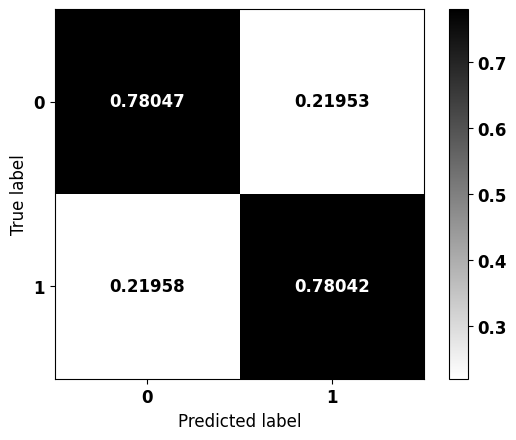


              precision    recall  f1-score   support

           0    0.81365   0.78047   0.79672     14859
           1    0.74319   0.78042   0.76135     12096

    accuracy                        0.78045     26955
   macro avg    0.77842   0.78045   0.77903     26955
weighted avg    0.78203   0.78045   0.78085     26955



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=1.075,
                    random_state=seed)

xgb.fit(X_train_boca_esto_colo, y_train_boca_esto_colo)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test_boca_esto_colo, y_test_boca_esto_colo)

#### **Optuna**

In [ ]:
params = {'n_estimators': 148,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 1.065

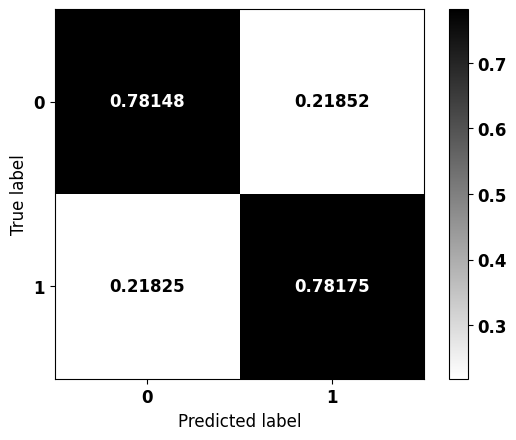


              precision    recall  f1-score   support

           0    0.81476   0.78148   0.79777     14859
           1    0.74439   0.78175   0.76261     12096

    accuracy                        0.78160     26955
   macro avg    0.77958   0.78161   0.78019     26955
weighted avg    0.78318   0.78160   0.78199     26955



In [ ]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train_boca_esto_colo, y_train_boca_esto_colo)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test_boca_esto_colo, y_test_boca_esto_colo)

### **LightGBM**


#### **Modelo base**

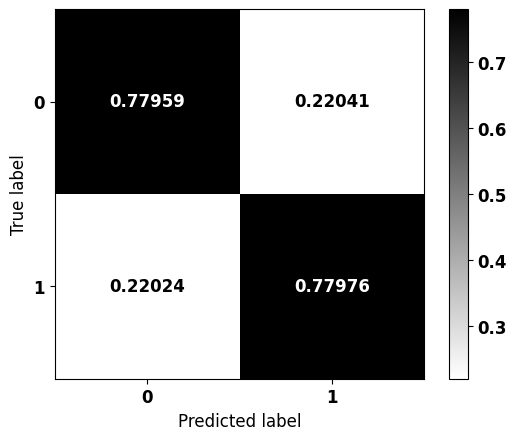


              precision    recall  f1-score   support

           0    0.81303   0.77959   0.79596     14859
           1    0.74227   0.77976   0.76055     12096

    accuracy                        0.77967     26955
   macro avg    0.77765   0.77968   0.77826     26955
weighted avg    0.78127   0.77967   0.78007     26955



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:1.068},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train_boca_esto_colo, y_train_boca_esto_colo)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test_boca_esto_colo, y_test_boca_esto_colo)

#### **Optuna**

In [ ]:
params = {'n_estimators': 141,
 'max_depth': 9,
 'learning_rate': 0.15,
 'min_child_weight': 5,
 'colsample_bytree': 0.6}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.065}

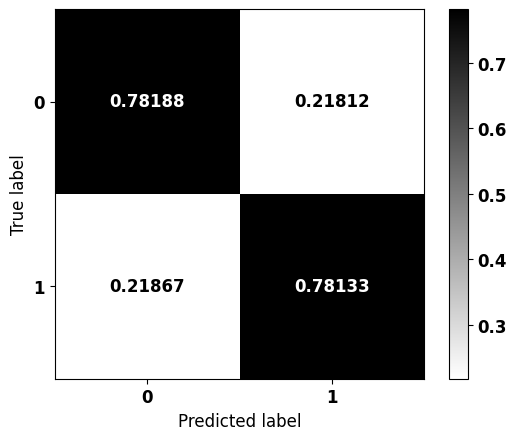


              precision    recall  f1-score   support

           0    0.81456   0.78188   0.79788     14859
           1    0.74464   0.78133   0.76255     12096

    accuracy                        0.78164     26955
   macro avg    0.77960   0.78161   0.78022     26955
weighted avg    0.78318   0.78164   0.78203     26955



In [ ]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train_boca_esto_colo, y_train_boca_esto_colo)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test_boca_esto_colo, y_test_boca_esto_colo)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test_boca_esto_colo, y_test_boca_esto_colo)
        score = m.score(X_test_boca_esto_colo, y_test_boca_esto_colo)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 1.065}, colsample_bytree=0.6,
               learning_rate=0.15, max_depth=9, min_child_weight=5,
               n_estimators=141, random_state=7, verbose=-1)


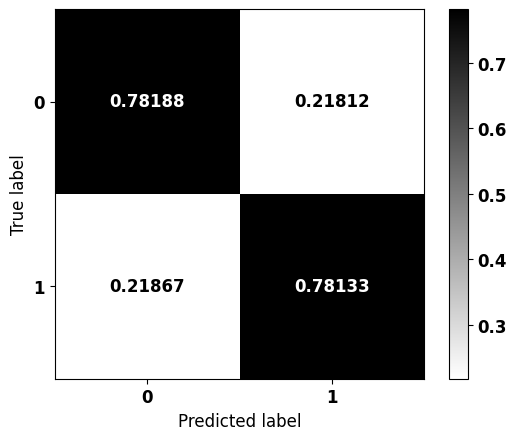


              precision    recall  f1-score   support

           0    0.81456   0.78188   0.79788     14859
           1    0.74464   0.78133   0.76255     12096

    accuracy                        0.78164     26955
   macro avg    0.77960   0.78161   0.78022     26955
weighted avg    0.78318   0.78164   0.78203     26955



In [ ]:
plot_confusion_matrix(best, X_test_boca_esto_colo, y_test_boca_esto_colo)

In [ ]:
# Cavidade Oral
X_test_boca_c = boca_teste.drop(columns=list_drop).copy()
y_test_boca_c = boca_teste.sobrevida_3anos.copy()

X_test_boca_c['TOPOGRUP'] = oe.transform(X_test_boca_c[['TOPOGRUP']])
X_test_boca_c['TOPOGRUP'] = ss.transform(X_test_boca_c[['TOPOGRUP']])

# Estômago
X_test_esto_c = esto_teste.drop(columns=list_drop).copy()
y_test_esto_c = esto_teste.sobrevida_3anos.copy()

X_test_esto_c['TOPOGRUP'] = oe.transform(X_test_esto_c[['TOPOGRUP']])
X_test_esto_c['TOPOGRUP'] = ss.transform(X_test_esto_c[['TOPOGRUP']])

# Colorretal
X_test_colo_c = colo_teste.drop(columns=list_drop).copy()
y_test_colo_c = colo_teste.sobrevida_3anos.copy()

X_test_colo_c['TOPOGRUP'] = oe.transform(X_test_colo_c[['TOPOGRUP']])
X_test_colo_c['TOPOGRUP'] = ss.transform(X_test_colo_c[['TOPOGRUP']])

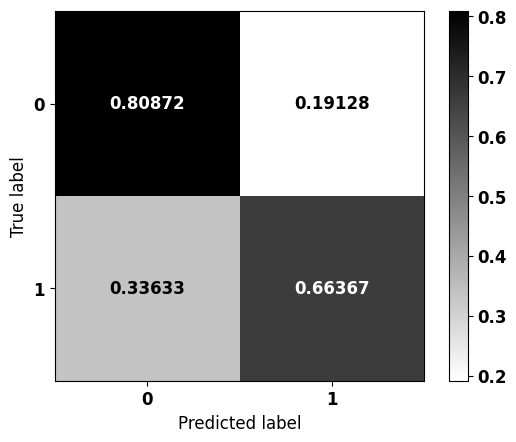


              precision    recall  f1-score   support

           0    0.77621   0.80872   0.79213      3534
           1    0.70634   0.66367   0.68434      2450

    accuracy                        0.74933      5984
   macro avg    0.74128   0.73619   0.73824      5984
weighted avg    0.74760   0.74933   0.74800      5984



In [ ]:
# Cavidade Oral
plot_confusion_matrix(best, X_test_boca_c, y_test_boca_c)

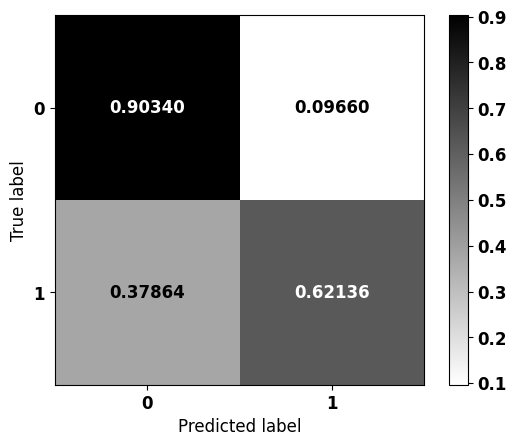


              precision    recall  f1-score   support

           0    0.86439   0.90340   0.88347      5052
           1    0.70655   0.62136   0.66123      1891

    accuracy                        0.82659      6943
   macro avg    0.78547   0.76238   0.77235      6943
weighted avg    0.82140   0.82659   0.82294      6943



In [ ]:
# Estômago
plot_confusion_matrix(best, X_test_esto_c, y_test_esto_c)

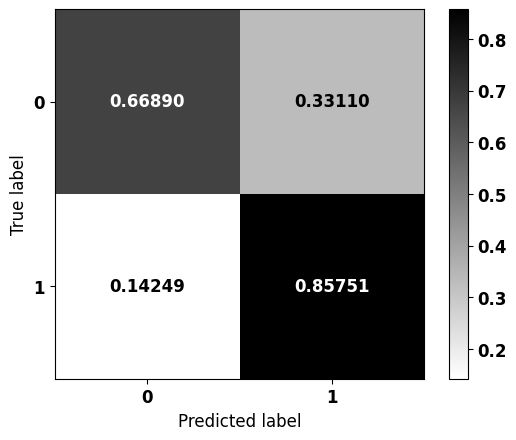


              precision    recall  f1-score   support

           0    0.79155   0.66890   0.72507      6273
           1    0.76200   0.85751   0.80694      7755

    accuracy                        0.77317     14028
   macro avg    0.77678   0.76320   0.76601     14028
weighted avg    0.77522   0.77317   0.77033     14028



In [ ]:
# Colorretal
plot_confusion_matrix(best, X_test_colo_c, y_test_colo_c)

### **Grade de matrizes de confusão**

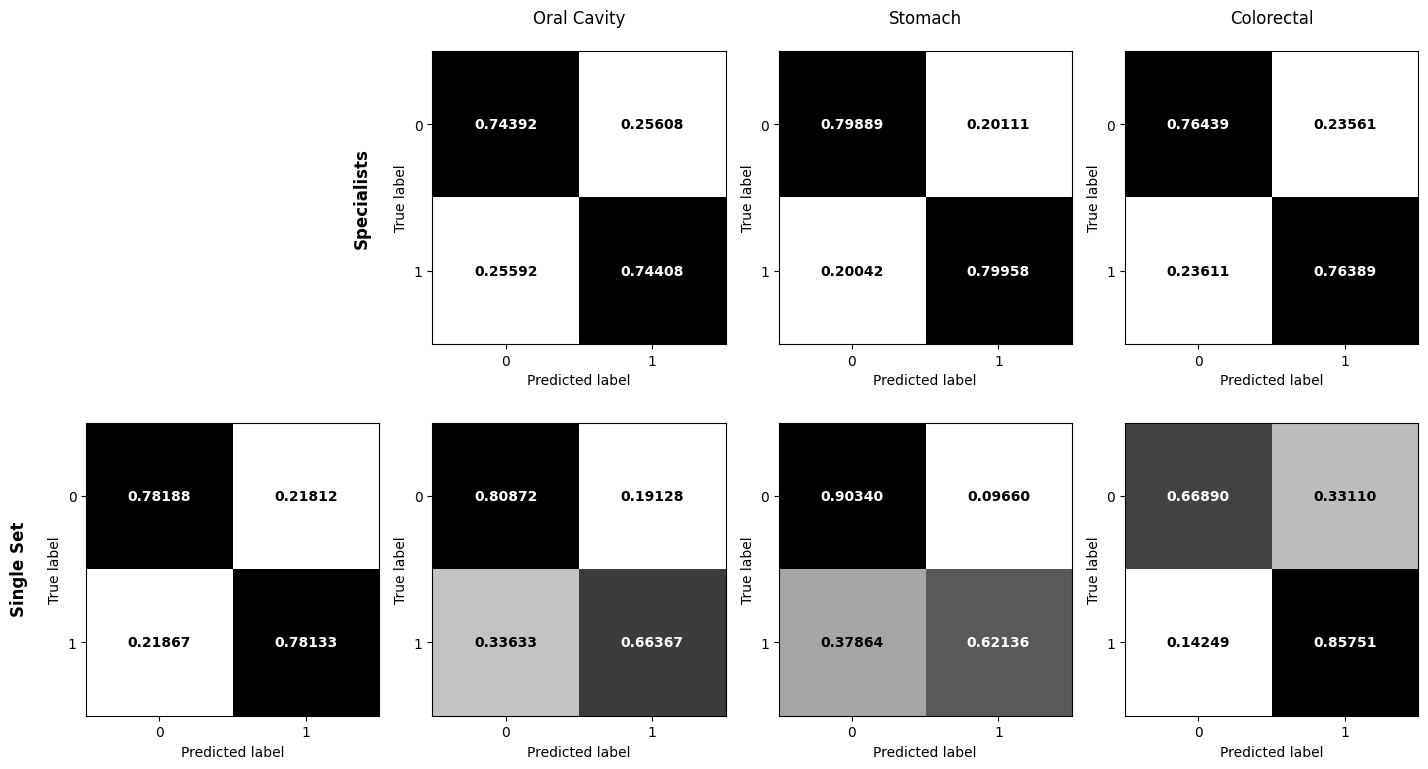

In [ ]:
# Títulos das colunas
titles = ['', 'Oral Cavity', 'Stomach', 'Colorectal']
names = ['Specialists', 'Single Set']

# Índices das posições a serem preenchidas com matrizes de confusão
positions_to_fill = {1: (best_boca, X_test_boca, y_test_boca),
                     2: (best_esto, X_test_esto, y_test_esto),
                     3: (best_colo, X_test_colo, y_test_colo),
                     4: (best, X_test_boca_esto_colo, y_test_boca_esto_colo),
                     5: (best, X_test_boca_c, y_test_boca_c),
                     6: (best, X_test_esto_c, y_test_esto_c),
                     7: (best, X_test_colo_c, y_test_colo_c)}

position = [0.733, 0.27]

# Configuração da figura com 2 linhas e 4 colunas
fig, axes = plt.subplots(2, 4, figsize=(14, 8))

for i, ax in enumerate(axes.flatten()):

    if i in positions_to_fill.keys():
        plot_confusion_matrix_v2(positions_to_fill[i][0],
                                 positions_to_fill[i][1],
                                 positions_to_fill[i][2],
                                 ax=ax)
    else:
        # Deixe as posições não especificadas em branco
        ax.axis('off')

# Adiciona títulos das colunas
for col_idx in range(4):
    axes[0, col_idx].set_title(titles[col_idx], fontsize=12, pad=20)

# Adiciona títulos das linhas
for row_idx in range(2):
    if row_idx == 0:
        fig.text(0.235, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')
    else:
        fig.text(-0.01, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')

# Ajuste dos espaços entre os subplots
plt.tight_layout()
plt.savefig(figures_path+'/boca_esto_colo.eps', bbox_inches='tight')

## **Esôfago com Cavidade Oral e Estômago**

In [ ]:
df2_treino.TOPOGRUP.value_counts()

TOPOGRUP
Estômago    20827
Boca        17951
Esôfago     10470
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df2_treino['TOPOGRUP'] = oe.fit_transform(df2_treino[['TOPOGRUP']])
df2_teste['TOPOGRUP'] = oe.transform(df2_teste[['TOPOGRUP']])

ss = StandardScaler()
df2_treino['TOPOGRUP'] = ss.fit_transform(df2_treino[['TOPOGRUP']])
df2_teste['TOPOGRUP'] = ss.transform(df2_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train_eso_boca_esto = df2_treino.drop(columns=list_drop).copy()
y_train_eso_boca_esto = df2_treino.sobrevida_3anos.copy()

# Teste
X_test_eso_boca_esto = df2_teste.drop(columns=list_drop).copy()
y_test_eso_boca_esto = df2_teste.sobrevida_3anos.copy()

X_train_eso_boca_esto.shape, y_train_eso_boca_esto.shape, X_test_eso_boca_esto.shape, y_test_eso_boca_esto.shape

((49248, 24), (49248,), (16418, 24), (16418,))

In [ ]:
feat_cols = X_train_eso_boca_esto.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

### **XGBoost**


#### **Modelo base**

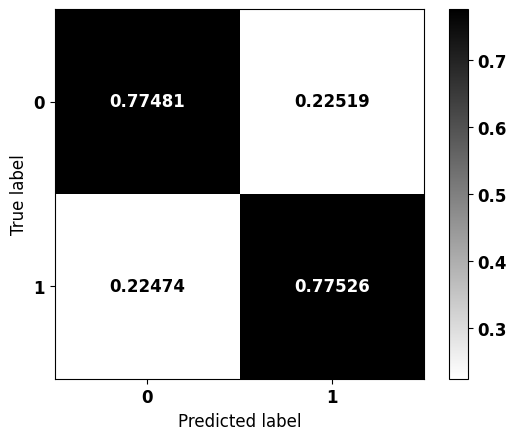


              precision    recall  f1-score   support

           0    0.89270   0.77481   0.82959     11608
           1    0.58789   0.77526   0.66870      4810

    accuracy                        0.77494     16418
   macro avg    0.74030   0.77504   0.74914     16418
weighted avg    0.80340   0.77494   0.78245     16418



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=4,
                    scale_pos_weight=2.315,
                    random_state=seed)

xgb.fit(X_train_eso_boca_esto, y_train_eso_boca_esto)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test_eso_boca_esto, y_test_eso_boca_esto)

#### **Optuna**

In [ ]:
params = {'n_estimators': 147,
 'max_depth': 5,
 'learning_rate': 0.15,
 'gamma': 0.0,
 'min_child_weight': 1,
 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 2.299

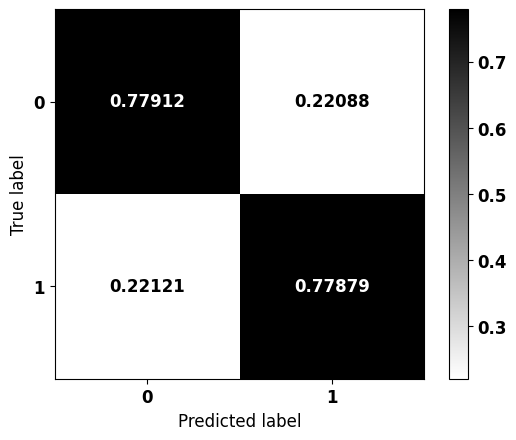


              precision    recall  f1-score   support

           0    0.89474   0.77912   0.83293     11608
           1    0.59366   0.77879   0.67374      4810

    accuracy                        0.77902     16418
   macro avg    0.74420   0.77896   0.75334     16418
weighted avg    0.80653   0.77902   0.78630     16418



In [ ]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train_eso_boca_esto, y_train_eso_boca_esto)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test_eso_boca_esto, y_test_eso_boca_esto)

### **LightGBM**


#### **Modelo base**

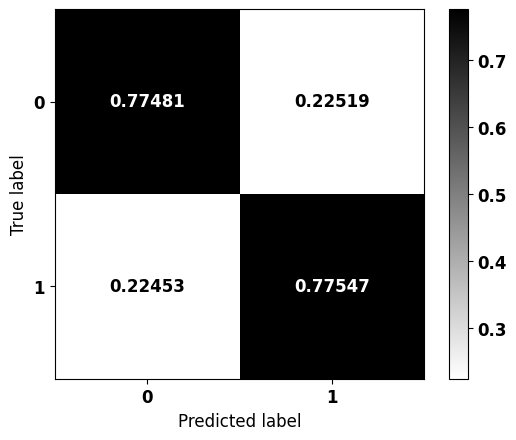


              precision    recall  f1-score   support

           0    0.89279   0.77481   0.82963     11608
           1    0.58796   0.77547   0.66882      4810

    accuracy                        0.77500     16418
   macro avg    0.74038   0.77514   0.74922     16418
weighted avg    0.80349   0.77500   0.78252     16418



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:2.31},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train_eso_boca_esto, y_train_eso_boca_esto)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test_eso_boca_esto, y_test_eso_boca_esto)

#### **Optuna**

In [ ]:
params = {'n_estimators': 127,
 'max_depth': 9,
 'learning_rate': 0.12,
 'min_child_weight': 5,
 'colsample_bytree': 0.6}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:2.301}

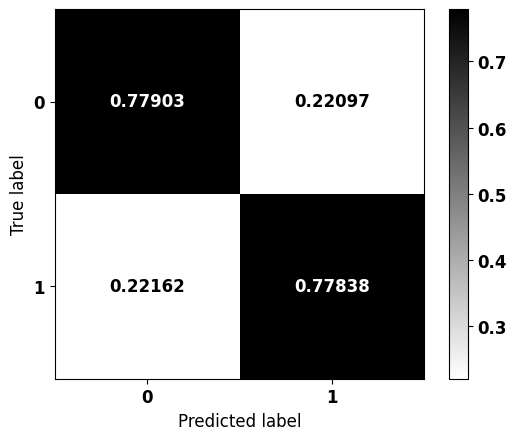


              precision    recall  f1-score   support

           0    0.89455   0.77903   0.83280     11608
           1    0.59344   0.77838   0.67344      4810

    accuracy                        0.77884     16418
   macro avg    0.74399   0.77871   0.75312     16418
weighted avg    0.80633   0.77884   0.78612     16418



In [ ]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train_eso_boca_esto, y_train_eso_boca_esto)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test_eso_boca_esto, y_test_eso_boca_esto)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test_eso_boca_esto, y_test_eso_boca_esto)
        score = m.score(X_test_eso_boca_esto, y_test_eso_boca_esto)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=147, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


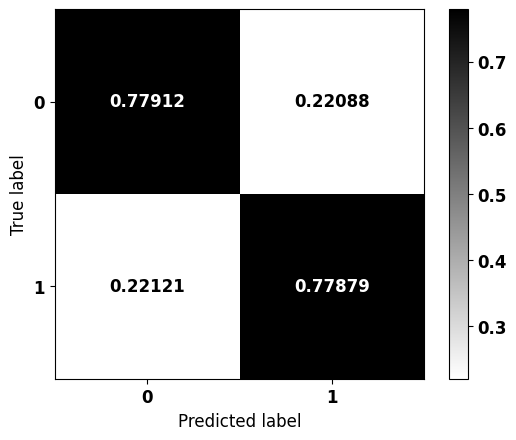


              precision    recall  f1-score   support

           0    0.89474   0.77912   0.83293     11608
           1    0.59366   0.77879   0.67374      4810

    accuracy                        0.77902     16418
   macro avg    0.74420   0.77896   0.75334     16418
weighted avg    0.80653   0.77902   0.78630     16418



In [ ]:
plot_confusion_matrix(best, X_test_eso_boca_esto, y_test_eso_boca_esto)

In [ ]:
# Esôfago
X_test_eso_c = eso_teste.drop(columns=list_drop).copy()
y_test_eso_c = eso_teste.sobrevida_3anos.copy()

X_test_eso_c['TOPOGRUP'] = oe.transform(X_test_eso_c[['TOPOGRUP']])
X_test_eso_c['TOPOGRUP'] = ss.transform(X_test_eso_c[['TOPOGRUP']])

# Cavidade Oral
X_test_boca_c = boca_teste.drop(columns=list_drop).copy()
y_test_boca_c = boca_teste.sobrevida_3anos.copy()

X_test_boca_c['TOPOGRUP'] = oe.transform(X_test_boca_c[['TOPOGRUP']])
X_test_boca_c['TOPOGRUP'] = ss.transform(X_test_boca_c[['TOPOGRUP']])

# Estômago
X_test_esto_c = esto_teste.drop(columns=list_drop).copy()
y_test_esto_c = esto_teste.sobrevida_3anos.copy()

X_test_esto_c['TOPOGRUP'] = oe.transform(X_test_esto_c[['TOPOGRUP']])
X_test_esto_c['TOPOGRUP'] = ss.transform(X_test_esto_c[['TOPOGRUP']])

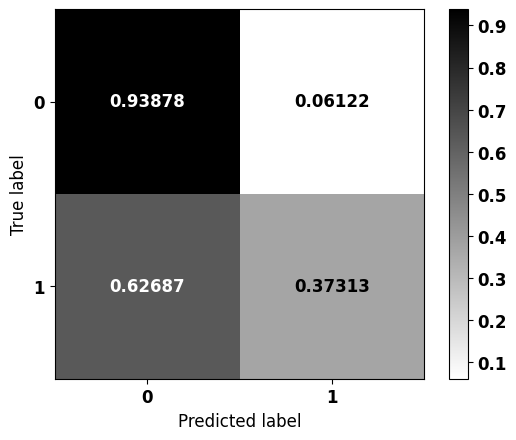


              precision    recall  f1-score   support

           0    0.90610   0.93878   0.92215      3022
           1    0.48611   0.37313   0.42220       469

    accuracy                        0.86279      3491
   macro avg    0.69611   0.65596   0.67217      3491
weighted avg    0.84968   0.86279   0.85498      3491



In [ ]:
# Esôfago
plot_confusion_matrix(best, X_test_eso_c, y_test_eso_c)

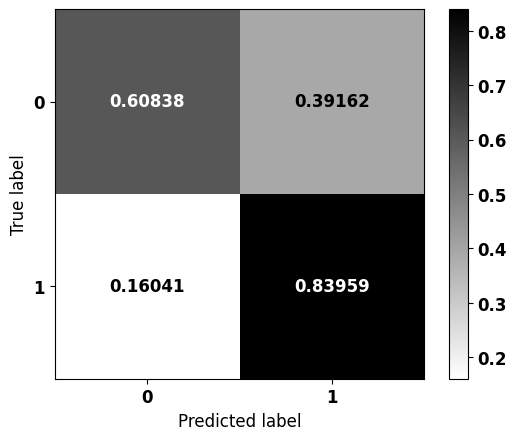


              precision    recall  f1-score   support

           0    0.84546   0.60838   0.70759      3534
           1    0.59779   0.83959   0.69835      2450

    accuracy                        0.70304      5984
   macro avg    0.72162   0.72398   0.70297      5984
weighted avg    0.74406   0.70304   0.70381      5984



In [ ]:
# Cavidade Oral
plot_confusion_matrix(best, X_test_boca_c, y_test_boca_c)

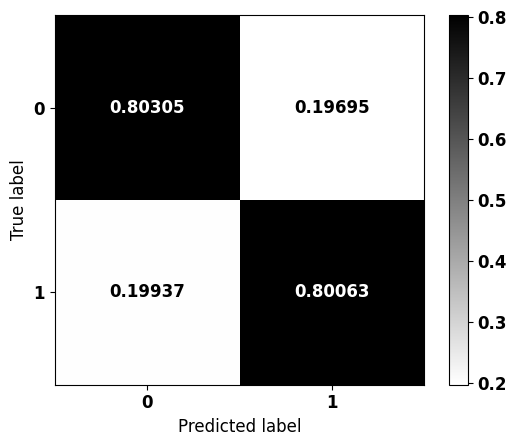


              precision    recall  f1-score   support

           0    0.91498   0.80305   0.85537      5052
           1    0.60343   0.80063   0.68818      1891

    accuracy                        0.80239      6943
   macro avg    0.75920   0.80184   0.77177      6943
weighted avg    0.83012   0.80239   0.80983      6943



In [ ]:
# Estômago
plot_confusion_matrix(best, X_test_esto_c, y_test_esto_c)

### **Grade de matrizes de confusão**

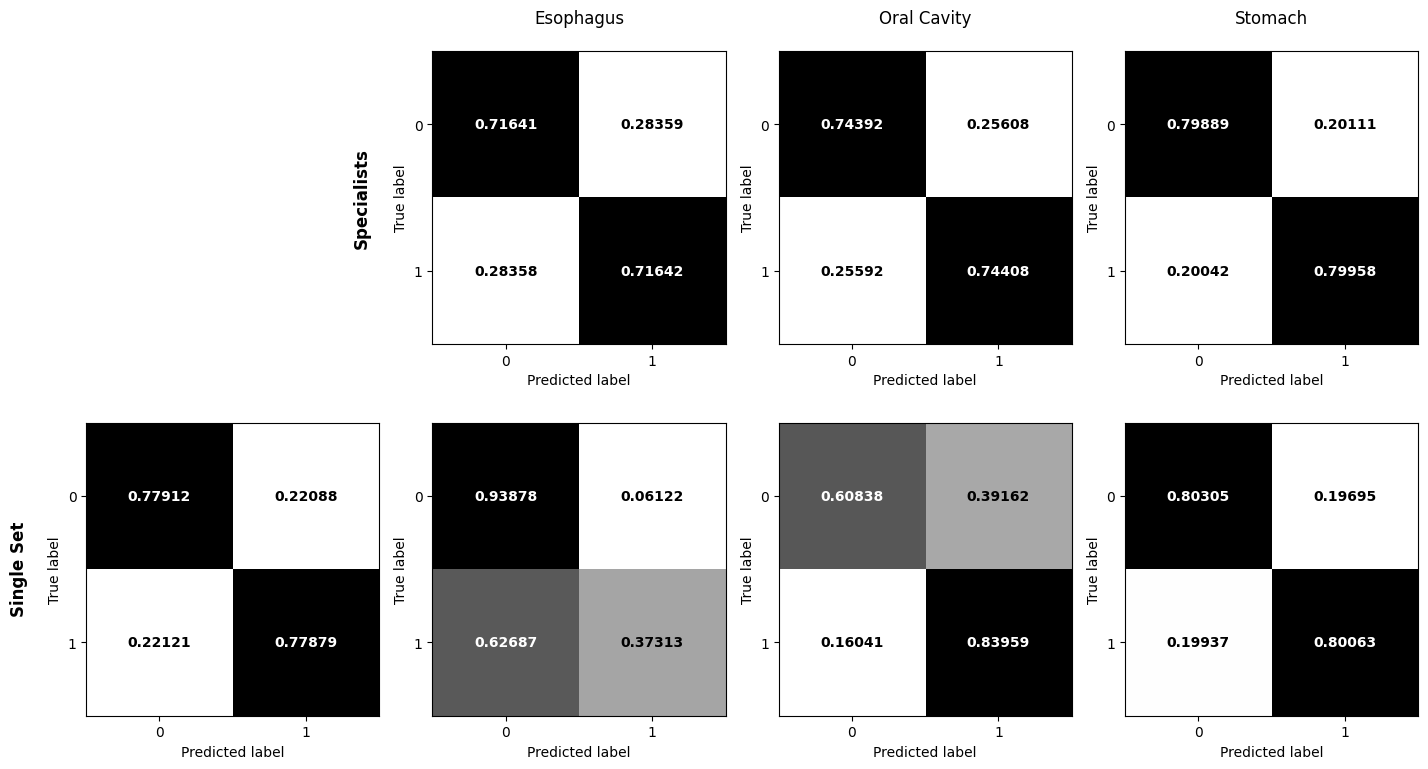

In [ ]:
# Títulos das colunas
titles = ['', 'Esophagus', 'Oral Cavity', 'Stomach']
names = ['Specialists', 'Single Set']

# Índices das posições a serem preenchidas com matrizes de confusão
positions_to_fill = {1: (best_eso, X_test_eso, y_test_eso),
                     2: (best_boca, X_test_boca, y_test_boca),
                     3: (best_esto, X_test_esto, y_test_esto),
                     4: (best, X_test_eso_boca_esto, y_test_eso_boca_esto),
                     5: (best, X_test_eso_c, y_test_eso_c),
                     6: (best, X_test_boca_c, y_test_boca_c),
                     7: (best, X_test_esto_c, y_test_esto_c)}

position = [0.733, 0.27]

# Configuração da figura com 2 linhas e 4 colunas
fig, axes = plt.subplots(2, 4, figsize=(14, 8))

for i, ax in enumerate(axes.flatten()):

    if i in positions_to_fill.keys():
        plot_confusion_matrix_v2(positions_to_fill[i][0],
                                 positions_to_fill[i][1],
                                 positions_to_fill[i][2],
                                 ax=ax)
    else:
        # Deixe as posições não especificadas em branco
        ax.axis('off')

# Adiciona títulos das colunas
for col_idx in range(4):
    axes[0, col_idx].set_title(titles[col_idx], fontsize=12, pad=20)

# Adiciona títulos das linhas
for row_idx in range(2):
    if row_idx == 0:
        fig.text(0.235, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')
    else:
        fig.text(-0.01, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')

# Ajuste dos espaços entre os subplots
plt.tight_layout()
plt.savefig(figures_path+'/eso_boca_esto.eps', bbox_inches='tight')

## **Intestino Delgado com Cavidade Oral e Estômago**

In [ ]:
df4_treino.TOPOGRUP.value_counts()

TOPOGRUP
Estômago    20827
Boca        17951
Delgado      1195
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df4_treino['TOPOGRUP'] = oe.fit_transform(df4_treino[['TOPOGRUP']])
df4_teste['TOPOGRUP'] = oe.transform(df4_teste[['TOPOGRUP']])

ss = StandardScaler()
df4_treino['TOPOGRUP'] = ss.fit_transform(df4_treino[['TOPOGRUP']])
df4_teste['TOPOGRUP'] = ss.transform(df4_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train_delg_boca_esto = df4_treino.drop(columns=list_drop).copy()
y_train_delg_boca_esto = df4_treino.sobrevida_3anos.copy()

# Teste
X_test_delg_boca_esto = df4_teste.drop(columns=list_drop).copy()
y_test_delg_boca_esto = df4_teste.sobrevida_3anos.copy()

X_train_delg_boca_esto.shape, y_train_delg_boca_esto.shape, X_test_delg_boca_esto.shape, y_test_delg_boca_esto.shape

((39973, 24), (39973,), (13326, 24), (13326,))

In [ ]:
feat_cols = X_train_delg_boca_esto.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

### **XGBoost**


#### **Modelo base**

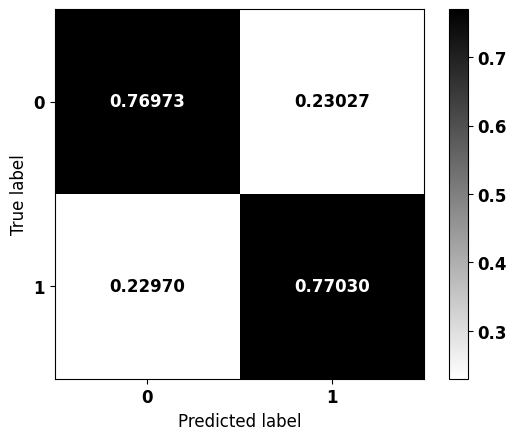


              precision    recall  f1-score   support

           0    0.86721   0.76973   0.81557      8807
           1    0.63188   0.77030   0.69426      4519

    accuracy                        0.76992     13326
   macro avg    0.74954   0.77002   0.75491     13326
weighted avg    0.78741   0.76992   0.77443     13326



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=4,
                    scale_pos_weight=1.77,
                    random_state=seed)

xgb.fit(X_train_delg_boca_esto, y_train_delg_boca_esto)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test_delg_boca_esto, y_test_delg_boca_esto)

#### **Optuna**

In [ ]:
params = {'n_estimators': 147,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'min_child_weight': 7,
 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 1.737

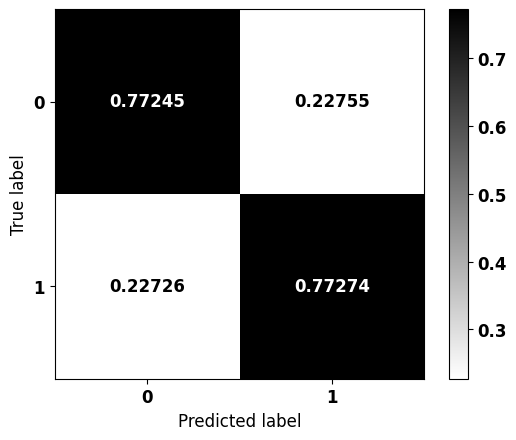


              precision    recall  f1-score   support

           0    0.86884   0.77245   0.81782      8807
           1    0.63537   0.77274   0.69735      4519

    accuracy                        0.77255     13326
   macro avg    0.75210   0.77260   0.75758     13326
weighted avg    0.78967   0.77255   0.77697     13326



In [ ]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train_delg_boca_esto, y_train_delg_boca_esto)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test_delg_boca_esto, y_test_delg_boca_esto)

### **LightGBM**


#### **Modelo base**

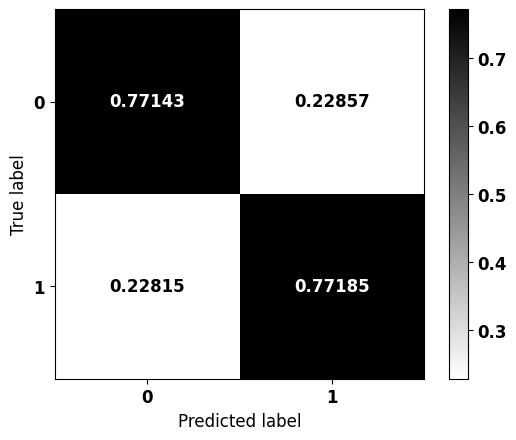


              precision    recall  f1-score   support

           0    0.86824   0.77143   0.81698      8807
           1    0.63407   0.77185   0.69621      4519

    accuracy                        0.77157     13326
   macro avg    0.75115   0.77164   0.75659     13326
weighted avg    0.78883   0.77157   0.77602     13326



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:1.7374},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train_delg_boca_esto, y_train_delg_boca_esto)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test_delg_boca_esto, y_test_delg_boca_esto)

#### **Optuna**

In [ ]:
params = {'n_estimators': 140,
 'max_depth': 8,
 'learning_rate': 0.08,
 'min_child_weight': 4,
 'colsample_bytree': 0.7}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.721}

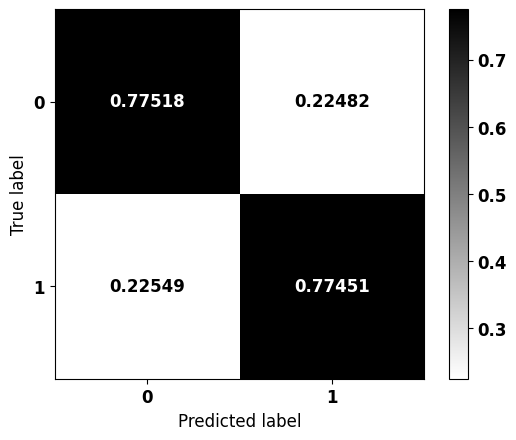


              precision    recall  f1-score   support

           0    0.87012   0.77518   0.81991      8807
           1    0.63869   0.77451   0.70007      4519

    accuracy                        0.77495     13326
   macro avg    0.75441   0.77484   0.75999     13326
weighted avg    0.79164   0.77495   0.77927     13326



In [ ]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train_delg_boca_esto, y_train_delg_boca_esto)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test_delg_boca_esto, y_test_delg_boca_esto)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test_delg_boca_esto, y_test_delg_boca_esto)
        score = m.score(X_test_delg_boca_esto, y_test_delg_boca_esto)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 1.721}, colsample_bytree=0.7,
               learning_rate=0.08, max_depth=8, min_child_weight=4,
               n_estimators=140, random_state=7, verbose=-1)


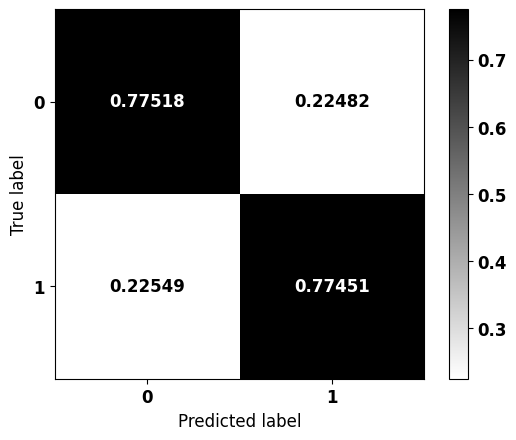


              precision    recall  f1-score   support

           0    0.87012   0.77518   0.81991      8807
           1    0.63869   0.77451   0.70007      4519

    accuracy                        0.77495     13326
   macro avg    0.75441   0.77484   0.75999     13326
weighted avg    0.79164   0.77495   0.77927     13326



In [ ]:
plot_confusion_matrix(best, X_test_delg_boca_esto, y_test_delg_boca_esto)

In [ ]:
# Cavidade Oral
X_test_boca_c = boca_teste.drop(columns=list_drop).copy()
y_test_boca_c = boca_teste.sobrevida_3anos.copy()

X_test_boca_c['TOPOGRUP'] = oe.transform(X_test_boca_c[['TOPOGRUP']])
X_test_boca_c['TOPOGRUP'] = ss.transform(X_test_boca_c[['TOPOGRUP']])

# Estômago
X_test_esto_c = esto_teste.drop(columns=list_drop).copy()
y_test_esto_c = esto_teste.sobrevida_3anos.copy()

X_test_esto_c['TOPOGRUP'] = oe.transform(X_test_esto_c[['TOPOGRUP']])
X_test_esto_c['TOPOGRUP'] = ss.transform(X_test_esto_c[['TOPOGRUP']])

# Intestino Delgado
X_test_delg_c = delg_teste.drop(columns=list_drop).copy()
y_test_delg_c = delg_teste.sobrevida_3anos.copy()

X_test_delg_c['TOPOGRUP'] = oe.transform(X_test_delg_c[['TOPOGRUP']])
X_test_delg_c['TOPOGRUP'] = ss.transform(X_test_delg_c[['TOPOGRUP']])

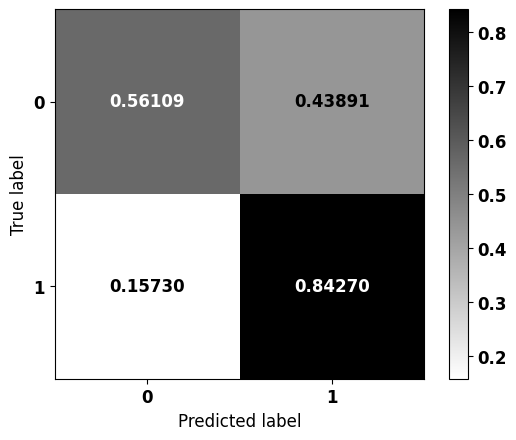


              precision    recall  f1-score   support

           0    0.81579   0.56109   0.66488       221
           1    0.60729   0.84270   0.70588       178

    accuracy                        0.68672       399
   macro avg    0.71154   0.70189   0.68538       399
weighted avg    0.72277   0.68672   0.68317       399



In [ ]:
# Intestino Delgado
plot_confusion_matrix(best, X_test_delg_c, y_test_delg_c)

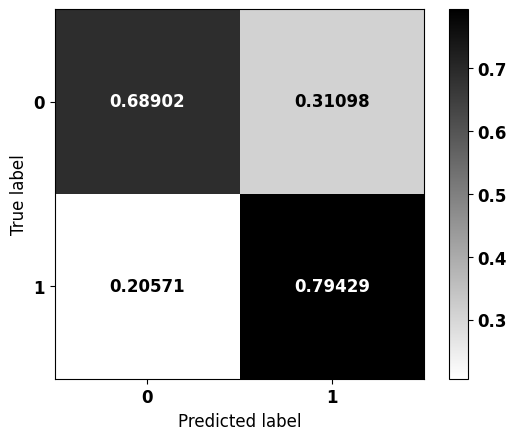


              precision    recall  f1-score   support

           0    0.82851   0.68902   0.75236      3534
           1    0.63908   0.79429   0.70828      2450

    accuracy                        0.73212      5984
   macro avg    0.73380   0.74165   0.73032      5984
weighted avg    0.75095   0.73212   0.73431      5984



In [ ]:
# Cavidade Oral
plot_confusion_matrix(best, X_test_boca_c, y_test_boca_c)

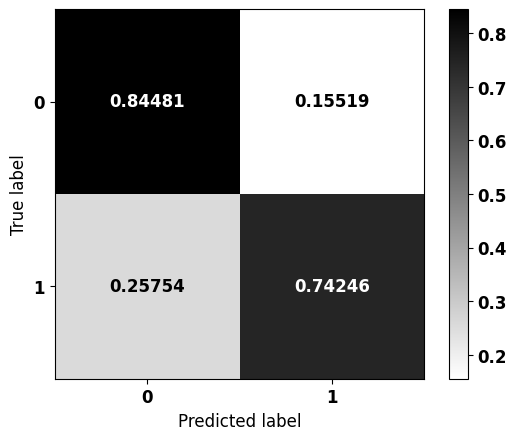


              precision    recall  f1-score   support

           0    0.89758   0.84481   0.87040      5052
           1    0.64168   0.74246   0.68840      1891

    accuracy                        0.81694      6943
   macro avg    0.76963   0.79364   0.77940      6943
weighted avg    0.82788   0.81694   0.82083      6943



In [ ]:
# Estômago
plot_confusion_matrix(best, X_test_esto_c, y_test_esto_c)

### **Grade de matrizes de confusão**

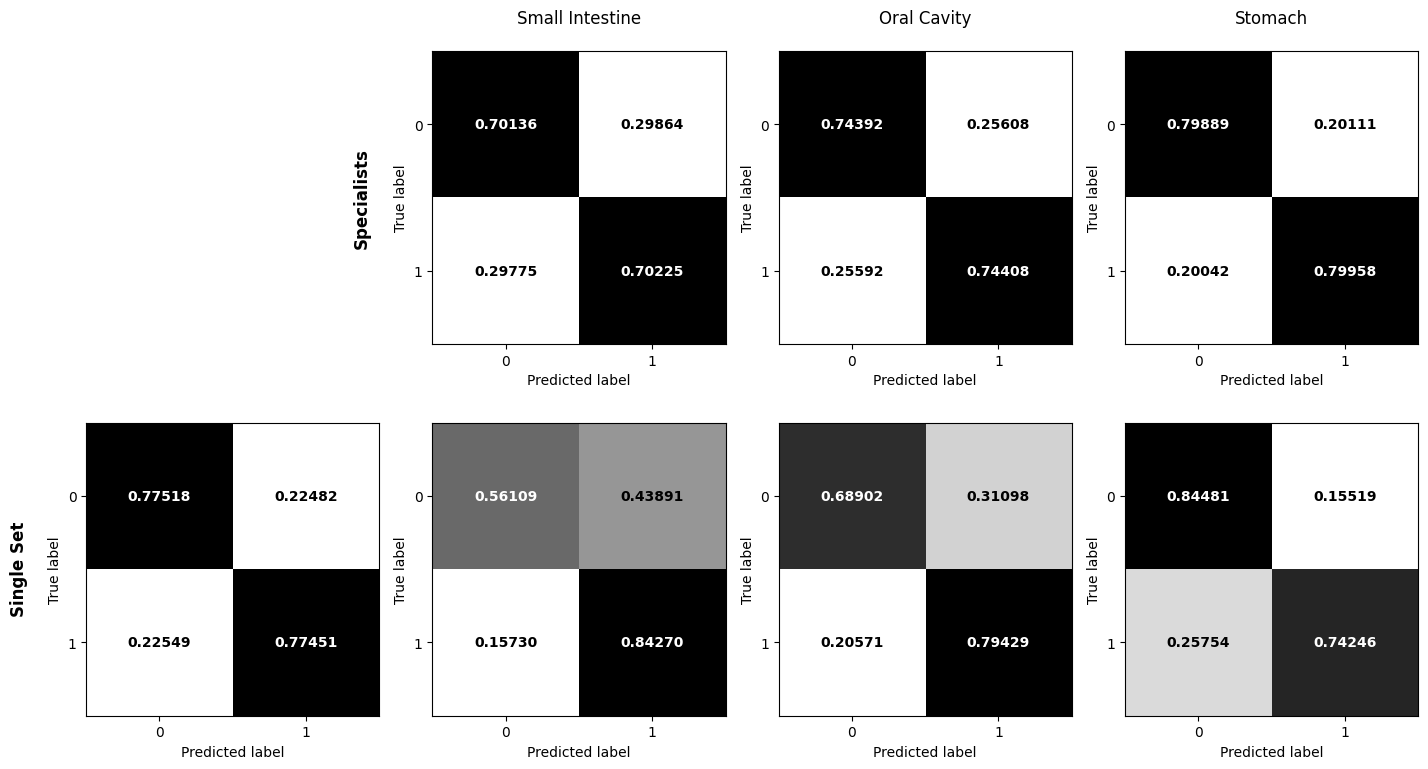

In [ ]:
# Títulos das colunas
titles = ['', 'Small Intestine', 'Oral Cavity', 'Stomach']
names = ['Specialists', 'Single Set']

# Índices das posições a serem preenchidas com matrizes de confusão
positions_to_fill = {1: (best_delg, X_test_delg, y_test_delg),
                     2: (best_boca, X_test_boca, y_test_boca),
                     3: (best_esto, X_test_esto, y_test_esto),
                     4: (best, X_test_delg_boca_esto, y_test_delg_boca_esto),
                     5: (best, X_test_delg_c, y_test_delg_c),
                     6: (best, X_test_boca_c, y_test_boca_c),
                     7: (best, X_test_esto_c, y_test_esto_c)}

position = [0.733, 0.27]

# Configuração da figura com 2 linhas e 4 colunas
fig, axes = plt.subplots(2, 4, figsize=(14, 8))

for i, ax in enumerate(axes.flatten()):

    if i in positions_to_fill.keys():
        plot_confusion_matrix_v2(positions_to_fill[i][0],
                                 positions_to_fill[i][1],
                                 positions_to_fill[i][2],
                                 ax=ax)
    else:
        # Deixe as posições não especificadas em branco
        ax.axis('off')

# Adiciona títulos das colunas
for col_idx in range(4):
    axes[0, col_idx].set_title(titles[col_idx], fontsize=12, pad=20)

# Adiciona títulos das linhas
for row_idx in range(2):
    if row_idx == 0:
        fig.text(0.235, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')
    else:
        fig.text(-0.01, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')

# Ajuste dos espaços entre os subplots
plt.tight_layout()
plt.savefig(figures_path+'/delg_boca_esto.eps', bbox_inches='tight')

## **Estômago com Colorretal**

In [ ]:
df3_treino.TOPOGRUP.value_counts()

TOPOGRUP
Colorretal    42083
Estômago      20827
Name: count, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df3_treino['TOPOGRUP'] = oe.fit_transform(df3_treino[['TOPOGRUP']])
df3_teste['TOPOGRUP'] = oe.transform(df3_teste[['TOPOGRUP']])

ss = StandardScaler()
df3_treino['TOPOGRUP'] = ss.fit_transform(df3_treino[['TOPOGRUP']])
df3_teste['TOPOGRUP'] = ss.transform(df3_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df3_treino.drop(columns=list_drop).copy()
y_train = df3_treino.sobrevida_3anos.copy()

# Teste
X_test = df3_teste.drop(columns=list_drop).copy()
y_test = df3_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((62910, 24), (62910,), (20971, 24), (20971,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

### **XGBoost**


#### **Modelo base**

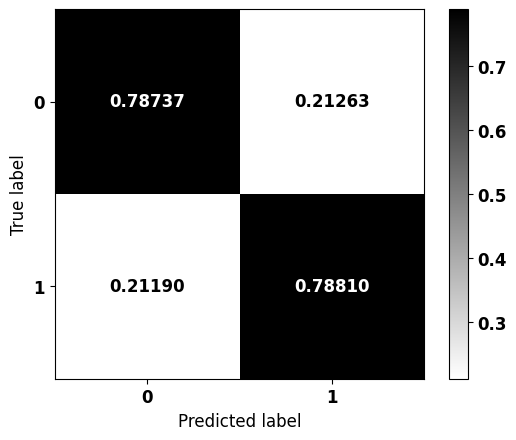


              precision    recall  f1-score   support

           0    0.81352   0.78737   0.80023     11325
           1    0.75944   0.78810   0.77350      9646

    accuracy                        0.78771     20971
   macro avg    0.78648   0.78774   0.78687     20971
weighted avg    0.78865   0.78771   0.78794     20971



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=0.96,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

#### **Optuna**

In [ ]:
params = {'n_estimators': 98,
 'max_depth': 6,
 'learning_rate': 0.15,
 'gamma': 0.1,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 0.9303

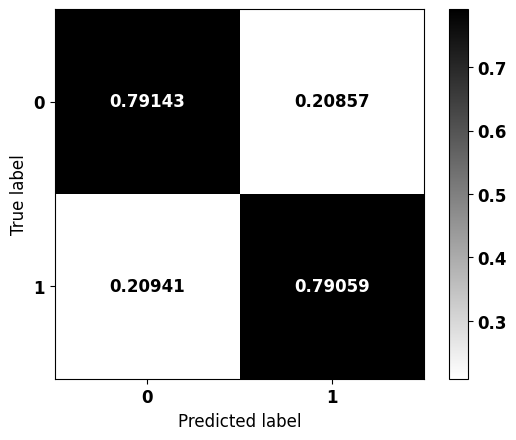


              precision    recall  f1-score   support

           0    0.81608   0.79143   0.80357     11325
           1    0.76352   0.79059   0.77682      9646

    accuracy                        0.79104     20971
   macro avg    0.78980   0.79101   0.79019     20971
weighted avg    0.79190   0.79104   0.79126     20971



In [ ]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

### **LightGBM**


#### **Modelo base**

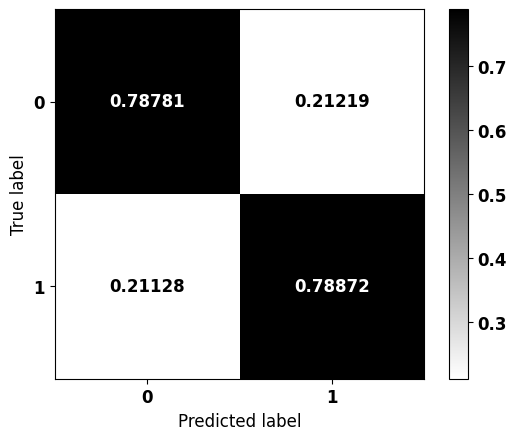


              precision    recall  f1-score   support

           0    0.81405   0.78781   0.80072     11325
           1    0.75996   0.78872   0.77408      9646

    accuracy                        0.78823     20971
   macro avg    0.78701   0.78827   0.78740     20971
weighted avg    0.78917   0.78823   0.78846     20971



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1.07, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

#### **Optuna**

In [ ]:
params = {'n_estimators': 138,
 'max_depth': 10,
 'learning_rate': 0.15,
 'min_child_weight': 2,
 'colsample_bytree': 0.6}

params['random_state'] = seed
params['class_weight'] = {0:1.0528, 1:1}

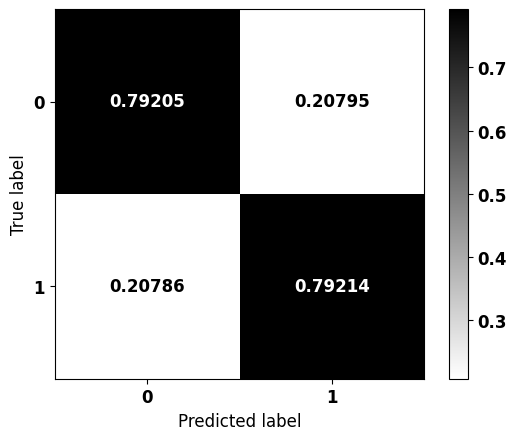


              precision    recall  f1-score   support

           0    0.81731   0.79205   0.80448     11325
           1    0.76441   0.79214   0.77803      9646

    accuracy                        0.79209     20971
   macro avg    0.79086   0.79210   0.79126     20971
weighted avg    0.79298   0.79209   0.79231     20971



In [ ]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1.0528, 1: 1}, colsample_bytree=0.6,
               learning_rate=0.15, max_depth=10, min_child_weight=2,
               n_estimators=138, random_state=7, verbose=-1)


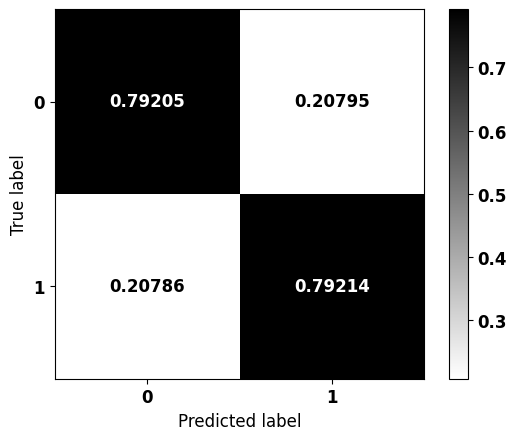


              precision    recall  f1-score   support

           0    0.81731   0.79205   0.80448     11325
           1    0.76441   0.79214   0.77803      9646

    accuracy                        0.79209     20971
   macro avg    0.79086   0.79210   0.79126     20971
weighted avg    0.79298   0.79209   0.79231     20971



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

In [ ]:
# Estômago
X_test_esto_c = esto_teste.drop(columns=list_drop).copy()
y_test_esto_c = esto_teste.sobrevida_3anos.copy()

X_test_esto_c['TOPOGRUP'] = oe.transform(X_test_esto_c[['TOPOGRUP']])
X_test_esto_c['TOPOGRUP'] = ss.transform(X_test_esto_c[['TOPOGRUP']])

# Colorretal
X_test_colo_c = colo_teste.drop(columns=list_drop).copy()
y_test_colo_c = colo_teste.sobrevida_3anos.copy()

X_test_colo_c['TOPOGRUP'] = oe.transform(X_test_colo_c[['TOPOGRUP']])
X_test_colo_c['TOPOGRUP'] = ss.transform(X_test_colo_c[['TOPOGRUP']])

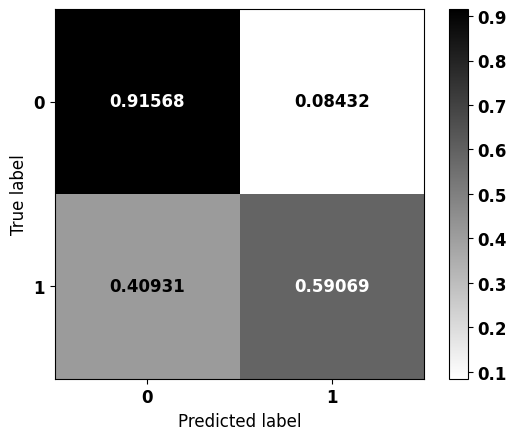


              precision    recall  f1-score   support

           0    0.85667   0.91568   0.88519      5052
           1    0.72391   0.59069   0.65055      1891

    accuracy                        0.82716      6943
   macro avg    0.79029   0.75318   0.76787      6943
weighted avg    0.82051   0.82716   0.82128      6943



In [ ]:
# Estômago
plot_confusion_matrix(best, X_test_esto_c, y_test_esto_c)

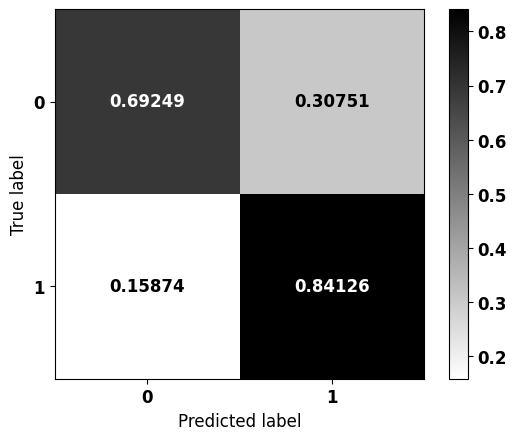


              precision    recall  f1-score   support

           0    0.77919   0.69249   0.73329      6273
           1    0.77180   0.84126   0.80503      7755

    accuracy                        0.77474     14028
   macro avg    0.77549   0.76688   0.76916     14028
weighted avg    0.77510   0.77474   0.77295     14028



In [ ]:
# Colorretal
plot_confusion_matrix(best, X_test_colo_c, y_test_colo_c)

### **Grade de matrizes de confusão**

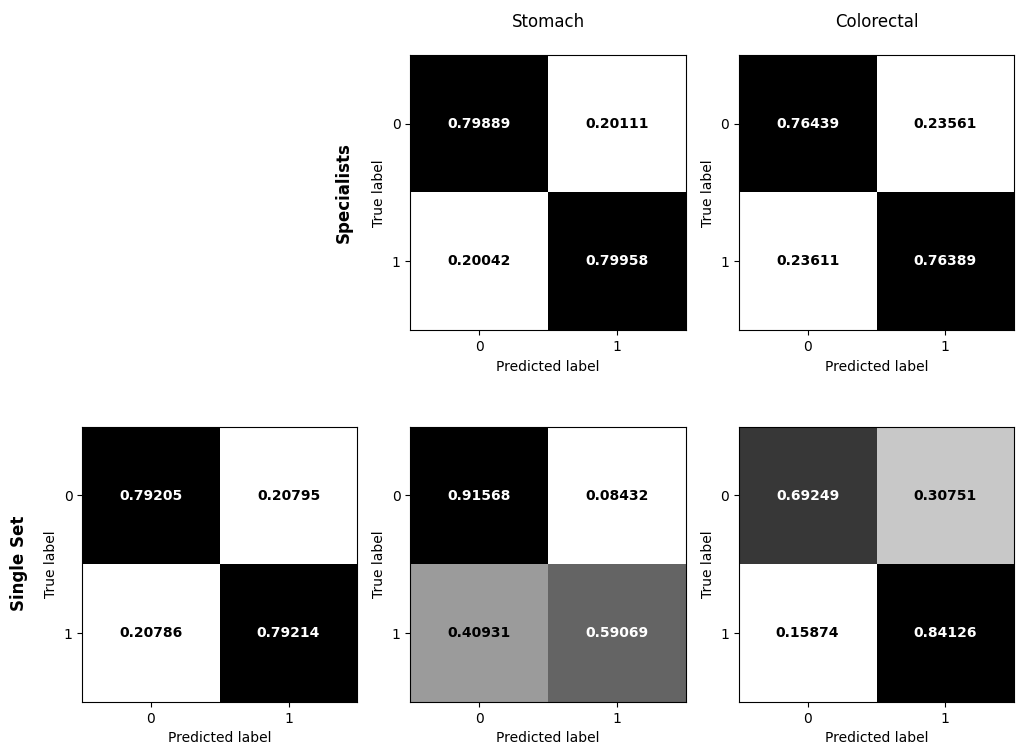

In [ ]:
# Títulos das colunas
titles = ['', 'Stomach', 'Colorectal']
names = ['Specialists', 'Single Set']

# Índices das posições a serem preenchidas com matrizes de confusão
positions_to_fill = {1: (best_esto, X_test_esto, y_test_esto),
                     2: (best_colo, X_test_colo, y_test_colo),
                     3: (best, X_test, y_test),
                     4: (best, X_test_esto_c, y_test_esto_c),
                     5: (best, X_test_colo_c, y_test_colo_c)}

position = [0.733, 0.27]

# Configuração da figura com 2 linhas e 3 colunas
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):

    if i in positions_to_fill.keys():
        plot_confusion_matrix_v2(positions_to_fill[i][0],
                                 positions_to_fill[i][1],
                                 positions_to_fill[i][2],
                                 ax=ax)
    else:
        # Deixe as posições não especificadas em branco
        ax.axis('off')

# Adiciona títulos das colunas
for col_idx in range(3):
    axes[0, col_idx].set_title(titles[col_idx], fontsize=12, pad=20)

# Adiciona títulos das linhas
for row_idx in range(2):
    if row_idx == 0:
        fig.text(0.315, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')
    else:
        fig.text(-0.01, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')

# Ajuste dos espaços entre os subplots
plt.tight_layout()
plt.savefig(figures_path+'/esto_colo.eps', bbox_inches='tight')

# **Juntos**

In [ ]:
%%capture

!gdown 129xV7F8XXr_4PqRtcR-GV7unEgNrL6qW --quiet # Sistema Digestório treino
!gdown 13aJGpxw_tAhT-44yuD-mRKjDsJcHwynU --quiet # Sistema Digestório teste

In [ ]:
df_sist_dig_treino = pd.read_csv('/content/sist_dig_treino.csv')
print(df_sist_dig_treino.shape)
df_sist_dig_treino.head(3)

(97924, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,-0.313399,-0.486452,0.889193,-0.855087,-0.933936,-0.777605,-1.053163,-1.057999,-0.846260,-0.052318,...,-0.702199,1.584652,0.669012,0.801956,-1.240717,0.520496,1.131402,2.122043,Boca,1
1,-0.775695,1.028664,0.875829,1.343451,-1.043802,1.054160,0.600930,-0.567847,-1.356322,-0.078540,...,-0.209650,-0.933152,-0.753735,0.794255,-0.968850,0.154944,0.964441,-0.475073,Colorretal,0
2,-0.815064,-0.486452,0.918482,-0.855087,1.070737,1.139022,-1.053163,0.945180,1.181669,-0.052318,...,0.732225,-0.949295,-0.763297,0.830259,0.464651,-1.748979,1.131402,-0.471244,Boca,0


In [ ]:
df_sist_dig_teste = pd.read_csv('/content/sist_dig_teste.csv')
print(df_sist_dig_teste.shape)
df_sist_dig_teste.head(3)

(32645, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.214492,1.028664,0.916336,1.343451,0.958036,1.054160,-1.664088,-0.567847,0.737288,-0.078540,...,-1.353129,-0.392930,-0.518012,0.692936,-0.968850,-0.870779,-1.036870,-0.475073,Colorretal,0
1,0.765536,-0.438574,0.929651,-0.867646,0.756823,0.008932,-0.545489,-1.026325,-1.178694,-0.053606,...,1.263874,-0.949246,-0.790110,0.836351,-1.175867,-1.674465,1.112286,-0.399978,Esôfago,0
2,0.773540,-0.486452,0.545758,1.148151,1.070737,-0.298449,-1.053163,0.945180,1.181669,-0.052318,...,-1.598714,0.679671,1.146449,-0.486755,-1.240717,-0.614241,-0.883859,-0.471244,Boca,1


In [ ]:
# DFs de teste para cada tipo
boca_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Boca']
oro_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Orofaringe']
eso_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Esôfago']
esto_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Estômago']
delg_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Delgado']
colo_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Colorretal']
anus_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Ânus']

boca_teste.shape, oro_teste.shape, eso_teste.shape, esto_teste.shape, delg_teste.shape, colo_teste.shape, anus_teste.shape

((5984, 25),
 (1231, 25),
 (3491, 25),
 (6943, 25),
 (399, 25),
 (14028, 25),
 (569, 25))

## **Sistema Digestório Juntos**

In [ ]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_sist_dig_treino['TOPOGRUP'] = oe.fit_transform(df_sist_dig_treino[['TOPOGRUP']])
df_sist_dig_teste['TOPOGRUP'] = oe.transform(df_sist_dig_teste[['TOPOGRUP']])

ss = StandardScaler()
df_sist_dig_treino['TOPOGRUP'] = ss.fit_transform(df_sist_dig_treino[['TOPOGRUP']])
df_sist_dig_teste['TOPOGRUP'] = ss.transform(df_sist_dig_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df_sist_dig_treino.drop(columns=list_drop).copy()
y_train = df_sist_dig_treino.sobrevida_3anos.copy()

# Teste
X_test = df_sist_dig_teste.drop(columns=list_drop).copy()
y_test = df_sist_dig_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((97924, 24), (97924,), (32645, 24), (32645,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

### **XGBoost**


#### **Modelo base**

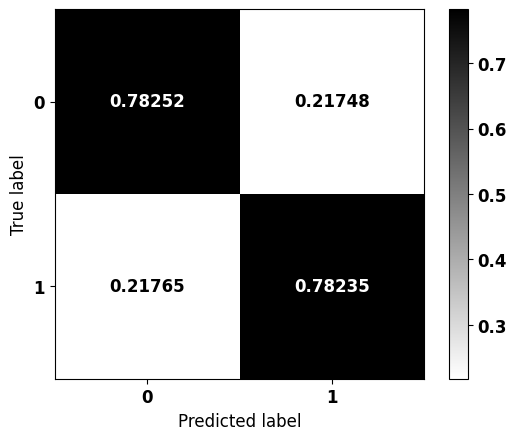


              precision    recall  f1-score   support

           0    0.83827   0.78252   0.80943     19275
           1    0.71390   0.78235   0.74656     13370

    accuracy                        0.78245     32645
   macro avg    0.77608   0.78243   0.77800     32645
weighted avg    0.78733   0.78245   0.78368     32645



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=1.31,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

#### **Optuna**

In [ ]:
params = {'n_estimators': 115,
 'max_depth': 6,
 'learning_rate': 0.15,
 'gamma': 0.1,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

params['random_state'] = seed
params['scale_pos_weight'] = 1.3091

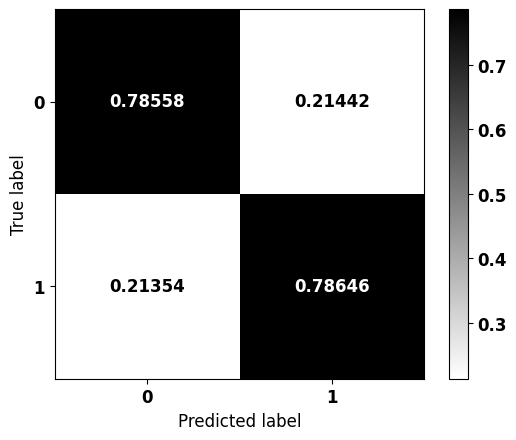


              precision    recall  f1-score   support

           0    0.84136   0.78558   0.81251     19275
           1    0.71785   0.78646   0.75059     13370

    accuracy                        0.78594     32645
   macro avg    0.77960   0.78602   0.78155     32645
weighted avg    0.79078   0.78594   0.78715     32645



In [ ]:
# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

### **LightGBM**


#### **Modelo base**

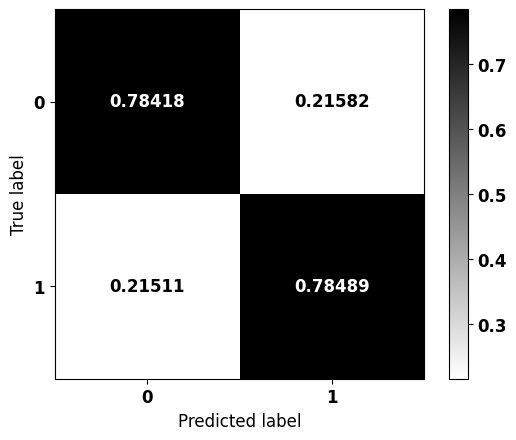


              precision    recall  f1-score   support

           0    0.84014   0.78418   0.81120     19275
           1    0.71612   0.78489   0.74893     13370

    accuracy                        0.78447     32645
   macro avg    0.77813   0.78453   0.78006     32645
weighted avg    0.78935   0.78447   0.78569     32645



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:1.29},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

#### **Optuna**

In [ ]:
params = {'n_estimators': 124,
 'max_depth': 9,
 'learning_rate': 0.16,
 'min_child_weight': 6,
 'colsample_bytree': 0.4}

params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.3032}

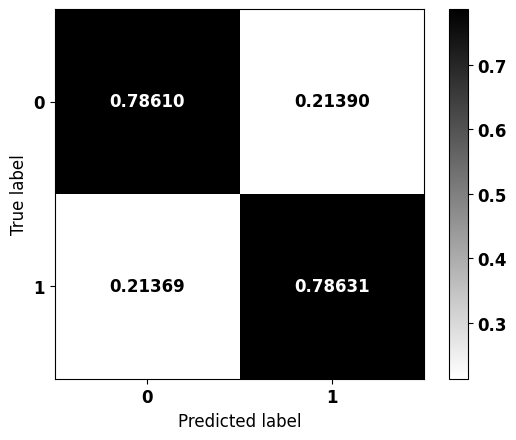


              precision    recall  f1-score   support

           0    0.84136   0.78610   0.81279     19275
           1    0.71830   0.78631   0.75077     13370

    accuracy                        0.78618     32645
   macro avg    0.77983   0.78620   0.78178     32645
weighted avg    0.79096   0.78618   0.78739     32645



In [ ]:
# Modelo com os melhores parâmetros
lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 1.3032}, colsample_bytree=0.4,
               learning_rate=0.16, max_depth=9, min_child_weight=6,
               n_estimators=124, random_state=7, verbose=-1)


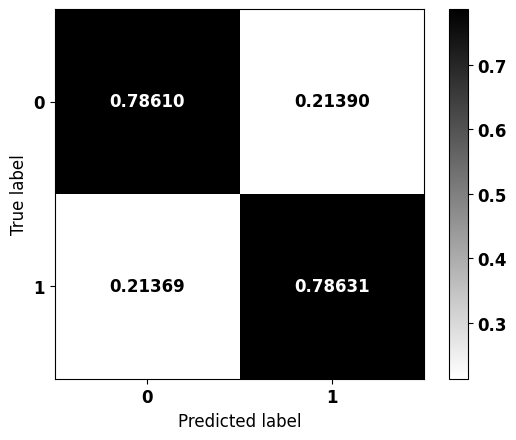


              precision    recall  f1-score   support

           0    0.84136   0.78610   0.81279     19275
           1    0.71830   0.78631   0.75077     13370

    accuracy                        0.78618     32645
   macro avg    0.77983   0.78620   0.78178     32645
weighted avg    0.79096   0.78618   0.78739     32645



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

In [ ]:
dfs = [boca_teste, colo_teste, oro_teste, eso_teste, esto_teste, anus_teste, delg_teste]

for i, df in enumerate(dfs):
    df['TOPOGRUP'] = oe.transform(df[['TOPOGRUP']])
    df['TOPOGRUP'] = ss.transform(df[['TOPOGRUP']])

<ipython-input-451-46ff95643005>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TOPOGRUP'] = oe.transform(df[['TOPOGRUP']])
<ipython-input-451-46ff95643005>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TOPOGRUP'] = ss.transform(df[['TOPOGRUP']])
<ipython-input-451-46ff95643005>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
# Cavidade Oral
X_test_boca_j = boca_teste.drop(columns=list_drop).copy()
y_test_boca_j = boca_teste.sobrevida_3anos.copy()

# Orofaringe
X_test_oro_j = oro_teste.drop(columns=list_drop).copy()
y_test_oro_j = oro_teste.sobrevida_3anos.copy()

# Esôfago
X_test_eso_j = eso_teste.drop(columns=list_drop).copy()
y_test_eso_j = eso_teste.sobrevida_3anos.copy()

# Estômago
X_test_esto_j = esto_teste.drop(columns=list_drop).copy()
y_test_esto_j = esto_teste.sobrevida_3anos.copy()

# Intestino Delgado
X_test_delg_j = delg_teste.drop(columns=list_drop).copy()
y_test_delg_j = delg_teste.sobrevida_3anos.copy()

# Colorretal
X_test_colo_j = colo_teste.drop(columns=list_drop).copy()
y_test_colo_j = colo_teste.sobrevida_3anos.copy()

# Ânus
X_test_anus_j = anus_teste.drop(columns=list_drop).copy()
y_test_anus_j = anus_teste.sobrevida_3anos.copy()

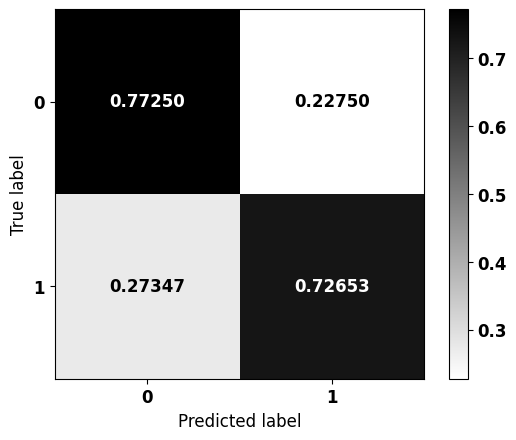


              precision    recall  f1-score   support

           0    0.80294   0.77250   0.78742      3534
           1    0.68885   0.72653   0.70719      2450

    accuracy                        0.75368      5984
   macro avg    0.74590   0.74951   0.74731      5984
weighted avg    0.75623   0.75368   0.75457      5984



In [ ]:
# Cavidade Oral
plot_confusion_matrix(best, X_test_boca_j, y_test_boca_j)

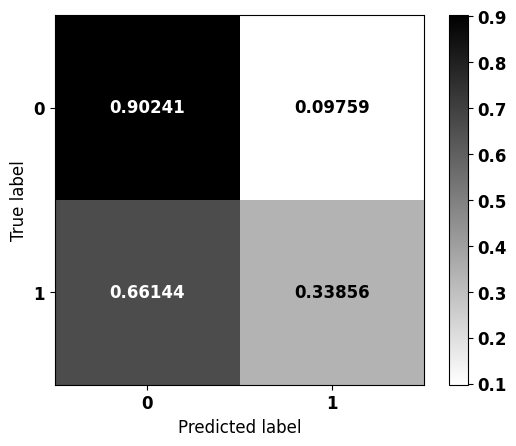


              precision    recall  f1-score   support

           0    0.79594   0.90241   0.84584       912
           1    0.54822   0.33856   0.41860       319

    accuracy                        0.75630      1231
   macro avg    0.67208   0.62049   0.63222      1231
weighted avg    0.73175   0.75630   0.73512      1231



In [ ]:
# Orofaringe
plot_confusion_matrix(best, X_test_oro_j, y_test_oro_j)

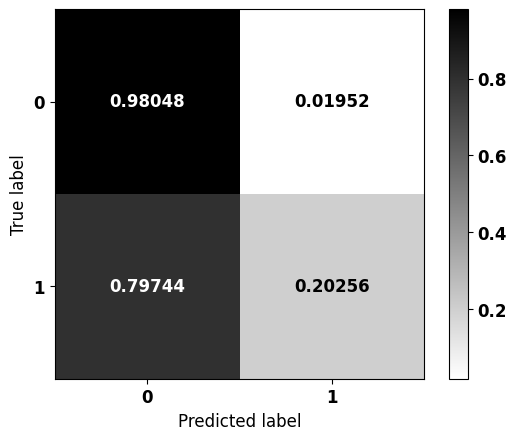


              precision    recall  f1-score   support

           0    0.88792   0.98048   0.93191      3022
           1    0.61688   0.20256   0.30498       469

    accuracy                        0.87597      3491
   macro avg    0.75240   0.59152   0.61844      3491
weighted avg    0.85151   0.87597   0.84768      3491



In [ ]:
# Esôfago
plot_confusion_matrix(best, X_test_eso_j, y_test_eso_j)

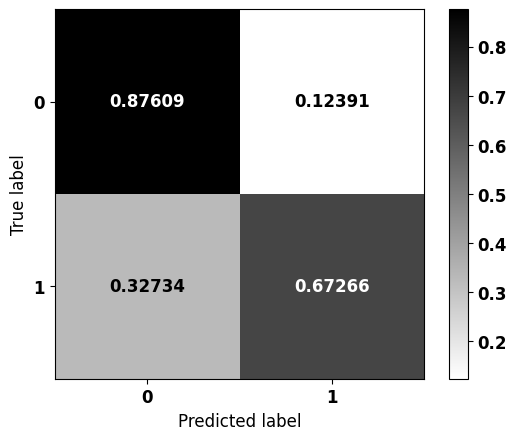


              precision    recall  f1-score   support

           0    0.87730   0.87609   0.87670      5052
           1    0.67018   0.67266   0.67142      1891

    accuracy                        0.82068      6943
   macro avg    0.77374   0.77437   0.77406      6943
weighted avg    0.82089   0.82068   0.82079      6943



In [ ]:
# Estômago
plot_confusion_matrix(best, X_test_esto_j, y_test_esto_j)

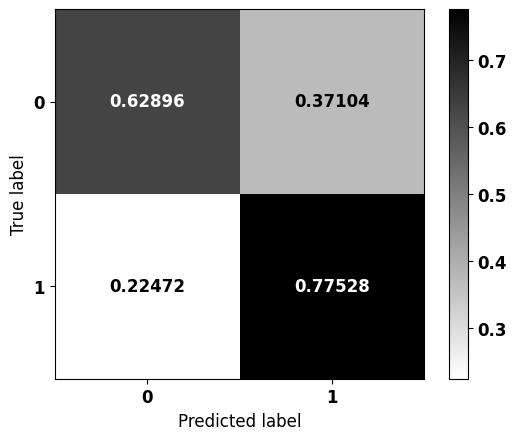


              precision    recall  f1-score   support

           0    0.77654   0.62896   0.69500       221
           1    0.62727   0.77528   0.69347       178

    accuracy                        0.69424       399
   macro avg    0.70190   0.70212   0.69423       399
weighted avg    0.70995   0.69424   0.69432       399



In [ ]:
# Intestino Delgado
plot_confusion_matrix(best, X_test_delg_j, y_test_delg_j)

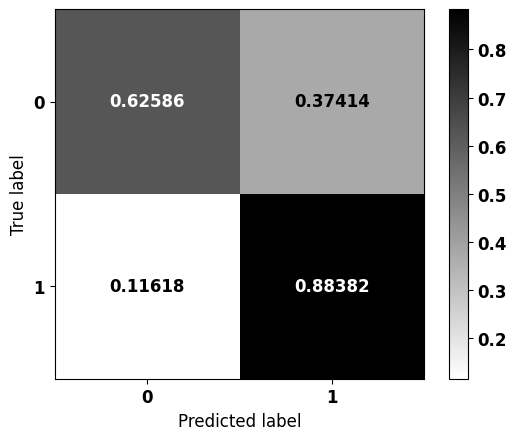


              precision    recall  f1-score   support

           0    0.81334   0.62586   0.70739      6273
           1    0.74492   0.88382   0.80845      7755

    accuracy                        0.76846     14028
   macro avg    0.77913   0.75484   0.75792     14028
weighted avg    0.77552   0.76846   0.76325     14028



In [ ]:
# Colorretal
plot_confusion_matrix(best, X_test_colo_j, y_test_colo_j)

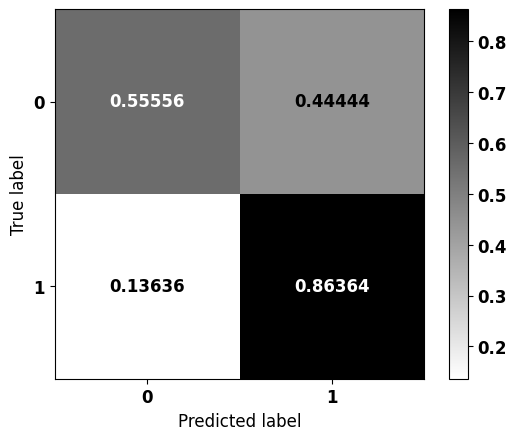


              precision    recall  f1-score   support

           0    0.77540   0.55556   0.64732       261
           1    0.69634   0.86364   0.77101       308

    accuracy                        0.72232       569
   macro avg    0.73587   0.70960   0.70917       569
weighted avg    0.73260   0.72232   0.71428       569



In [ ]:
# Ânus
plot_confusion_matrix(best, X_test_anus_j, y_test_anus_j)

## **Grade de matrizes de confusão**

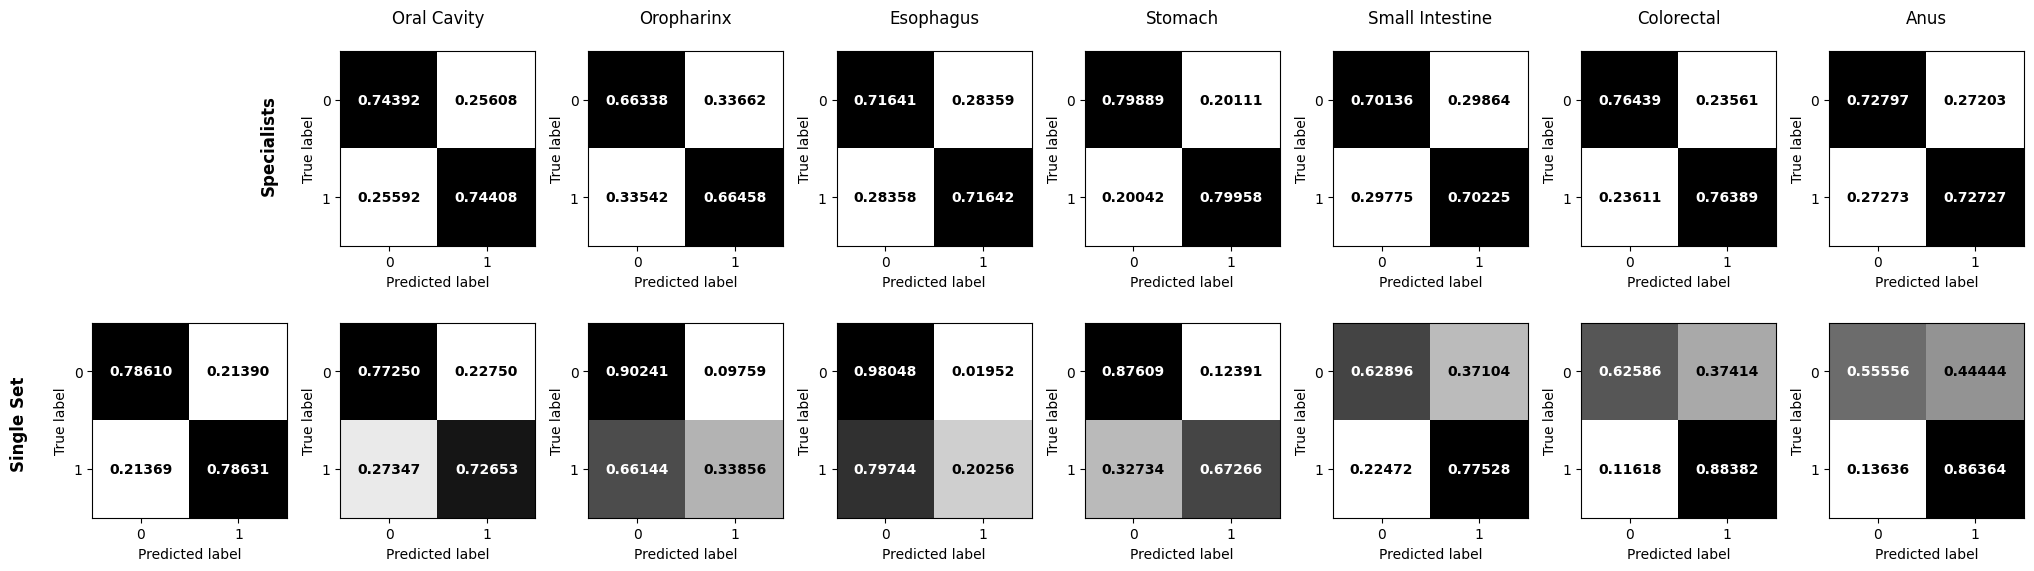

In [ ]:
# Títulos das colunas
titles = ['', 'Oral Cavity', 'Oropharinx', 'Esophagus', 'Stomach', 'Small Intestine',
          'Colorectal', 'Anus']
names = ['Specialists', 'Single Set']

# Índices das posições a serem preenchidas com matrizes de confusão
positions_to_fill = {1: (best_boca, X_test_boca, y_test_boca),
                     2: (best_oro, X_test_oro, y_test_oro),
                     3: (best_eso, X_test_eso, y_test_eso),
                     4: (best_esto, X_test_esto, y_test_esto),
                     5: (best_delg, X_test_delg, y_test_delg),
                     6: (best_colo, X_test_colo, y_test_colo),
                     7: (best_anus, X_test_anus, y_test_anus),
                     8: (best, X_test, y_test),
                     9: (best, X_test_boca_j, y_test_boca_j),
                     10: (best, X_test_oro_j, y_test_oro_j),
                     11: (best, X_test_eso_j, y_test_eso_j),
                     12: (best, X_test_esto_j, y_test_esto_j),
                     13: (best, X_test_delg_j, y_test_delg_j),
                     14: (best, X_test_colo_j, y_test_colo_j),
                     15: (best, X_test_anus_j, y_test_anus_j)}

position = [0.733, 0.27]

# Configuração da figura com 2 linhas e 8 colunas
fig, axes = plt.subplots(2, 8, figsize=(20, 6))

for i, ax in enumerate(axes.flatten()):

    if i in positions_to_fill.keys():
        plot_confusion_matrix_v2(positions_to_fill[i][0],
                                 positions_to_fill[i][1],
                                 positions_to_fill[i][2],
                                 ax=ax)
    else:
        # Deixe as posições não especificadas em branco
        ax.axis('off')

# Adiciona títulos das colunas
for col_idx in range(8):
    axes[0, col_idx].set_title(titles[col_idx], fontsize=12, pad=20)

# Adiciona títulos das linhas
for row_idx in range(2):
    if row_idx == 0:
        fig.text(0.115, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')
    else:
        fig.text(-0.01, position[row_idx], names[row_idx], va='center',
                 ha='center', rotation='vertical', fontsize=12, weight='bold')

# Ajuste dos espaços entre os subplots
plt.tight_layout()
plt.savefig(figures_path+'/digest_juntos.eps', bbox_inches='tight')